# Convolutional Networks

So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [1]:
# As usual, a bit of setup
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.
	There will be an option for Colab users and another for Jupyter (local) users.


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `cs231n/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [44]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])
# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))


Padding with pad = 1, older shape was (2, 3, 4, 4), new shape will be (2, 3, 6, 6).
Filters shape: (3, 3, 4, 4)
Output shape: (2, 3, 2, 2)
Testing conv_forward_naive
difference:  2.2121476575931688e-08


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

## Colab Users Only

Please execute the below cell to copy two cat images to the Colab VM.

In [ ]:
# Colab users only!
%mkdir -p cs231n/notebook_images
%cd drive/My\ Drive/$FOLDERNAME/cs231n
%cp -r notebook_images/ /content/cs231n/
%cd /content/

0 0
(3, 2, 2)
0 1
(3, 2, 2)
0 2
(3, 2, 2)
0 3
(3, 2, 2)
0 4
(3, 2, 2)
0 5
(3, 2, 2)
0 6
(3, 2, 2)
0 7
(3, 2, 2)
0 8
(3, 2, 2)
0 9
(3, 2, 2)
0 10
(3, 2, 2)
0 11
(3, 2, 2)
0 12
(3, 2, 2)
0 13
(3, 2, 2)
0 14
(3, 2, 2)
0 15
(3, 2, 2)
0 16
(3, 2, 2)
0 17
(3, 2, 2)
0 18
(3, 2, 2)
0 19
(3, 2, 2)
0 20
(3, 2, 2)
0 21
(3, 2, 2)
0 22
(3, 2, 2)
0 23
(3, 2, 2)
0 24
(3, 2, 2)
0 25
(3, 2, 2)
0 26
(3, 2, 2)
0 27
(3, 2, 2)
0 28
(3, 2, 2)
0 29
(3, 2, 2)
0 30
(3, 2, 2)
0 31
(3, 2, 2)
0 32
(3, 2, 2)
0 33
(3, 2, 2)
0 34
(3, 2, 2)
0 35
(3, 2, 2)
0 36
(3, 2, 2)
0 37
(3, 2, 2)
0 38
(3, 2, 2)
0 39
(3, 2, 2)
0 40
(3, 2, 2)
0 41
(3, 2, 2)
0 42
(3, 2, 2)
0 43
(3, 2, 2)
0 44
(3, 2, 2)
0 45
(3, 2, 2)
0 46
(3, 2, 2)
0 47
(3, 2, 2)
0 48
(3, 2, 2)
0 49
(3, 2, 2)
0 50
(3, 2, 2)
0 51
(3, 2, 2)
0 52
(3, 2, 2)
0 53
(3, 2, 2)
0 54
(3, 2, 2)
0 55
(3, 2, 2)
0 56
(3, 2, 2)
0 57
(3, 2, 2)
0 58
(3, 2, 2)
0 59
(3, 2, 2)
0 60
(3, 2, 2)
0 61
(3, 2, 2)
0 62
(3, 2, 2)
0 63
(3, 2, 2)
0 64
(3, 2, 2)
0 65
(3, 2, 2)
0 66
(3, 2, 2)
0 67


3 201
(3, 2, 1)
4 0
(3, 2, 2)
4 1
(3, 2, 2)
4 2
(3, 2, 2)
4 3
(3, 2, 2)
4 4
(3, 2, 2)
4 5
(3, 2, 2)
4 6
(3, 2, 2)
4 7
(3, 2, 2)
4 8
(3, 2, 2)
4 9
(3, 2, 2)
4 10
(3, 2, 2)
4 11
(3, 2, 2)
4 12
(3, 2, 2)
4 13
(3, 2, 2)
4 14
(3, 2, 2)
4 15
(3, 2, 2)
4 16
(3, 2, 2)
4 17
(3, 2, 2)
4 18
(3, 2, 2)
4 19
(3, 2, 2)
4 20
(3, 2, 2)
4 21
(3, 2, 2)
4 22
(3, 2, 2)
4 23
(3, 2, 2)
4 24
(3, 2, 2)
4 25
(3, 2, 2)
4 26
(3, 2, 2)
4 27
(3, 2, 2)
4 28
(3, 2, 2)
4 29
(3, 2, 2)
4 30
(3, 2, 2)
4 31
(3, 2, 2)
4 32
(3, 2, 2)
4 33
(3, 2, 2)
4 34
(3, 2, 2)
4 35
(3, 2, 2)
4 36
(3, 2, 2)
4 37
(3, 2, 2)
4 38
(3, 2, 2)
4 39
(3, 2, 2)
4 40
(3, 2, 2)
4 41
(3, 2, 2)
4 42
(3, 2, 2)
4 43
(3, 2, 2)
4 44
(3, 2, 2)
4 45
(3, 2, 2)
4 46
(3, 2, 2)
4 47
(3, 2, 2)
4 48
(3, 2, 2)
4 49
(3, 2, 2)
4 50
(3, 2, 2)
4 51
(3, 2, 2)
4 52
(3, 2, 2)
4 53
(3, 2, 2)
4 54
(3, 2, 2)
4 55
(3, 2, 2)
4 56
(3, 2, 2)
4 57
(3, 2, 2)
4 58
(3, 2, 2)
4 59
(3, 2, 2)
4 60
(3, 2, 2)
4 61
(3, 2, 2)
4 62
(3, 2, 2)
4 63
(3, 2, 2)
4 64
(3, 2, 2)
4 65
(3, 2, 2)
4 66

7 59
(3, 2, 2)
7 60
(3, 2, 2)
7 61
(3, 2, 2)
7 62
(3, 2, 2)
7 63
(3, 2, 2)
7 64
(3, 2, 2)
7 65
(3, 2, 2)
7 66
(3, 2, 2)
7 67
(3, 2, 2)
7 68
(3, 2, 2)
7 69
(3, 2, 2)
7 70
(3, 2, 2)
7 71
(3, 2, 2)
7 72
(3, 2, 2)
7 73
(3, 2, 2)
7 74
(3, 2, 2)
7 75
(3, 2, 2)
7 76
(3, 2, 2)
7 77
(3, 2, 2)
7 78
(3, 2, 2)
7 79
(3, 2, 2)
7 80
(3, 2, 2)
7 81
(3, 2, 2)
7 82
(3, 2, 2)
7 83
(3, 2, 2)
7 84
(3, 2, 2)
7 85
(3, 2, 2)
7 86
(3, 2, 2)
7 87
(3, 2, 2)
7 88
(3, 2, 2)
7 89
(3, 2, 2)
7 90
(3, 2, 2)
7 91
(3, 2, 2)
7 92
(3, 2, 2)
7 93
(3, 2, 2)
7 94
(3, 2, 2)
7 95
(3, 2, 2)
7 96
(3, 2, 2)
7 97
(3, 2, 2)
7 98
(3, 2, 2)
7 99
(3, 2, 2)
7 100
(3, 2, 2)
7 101
(3, 2, 2)
7 102
(3, 2, 2)
7 103
(3, 2, 2)
7 104
(3, 2, 2)
7 105
(3, 2, 2)
7 106
(3, 2, 2)
7 107
(3, 2, 2)
7 108
(3, 2, 2)
7 109
(3, 2, 2)
7 110
(3, 2, 2)
7 111
(3, 2, 2)
7 112
(3, 2, 2)
7 113
(3, 2, 2)
7 114
(3, 2, 2)
7 115
(3, 2, 2)
7 116
(3, 2, 2)
7 117
(3, 2, 2)
7 118
(3, 2, 2)
7 119
(3, 2, 2)
7 120
(3, 2, 2)
7 121
(3, 2, 2)
7 122
(3, 2, 2)
7 123
(3, 2, 2)
7

11 84
(3, 2, 2)
11 85
(3, 2, 2)
11 86
(3, 2, 2)
11 87
(3, 2, 2)
11 88
(3, 2, 2)
11 89
(3, 2, 2)
11 90
(3, 2, 2)
11 91
(3, 2, 2)
11 92
(3, 2, 2)
11 93
(3, 2, 2)
11 94
(3, 2, 2)
11 95
(3, 2, 2)
11 96
(3, 2, 2)
11 97
(3, 2, 2)
11 98
(3, 2, 2)
11 99
(3, 2, 2)
11 100
(3, 2, 2)
11 101
(3, 2, 2)
11 102
(3, 2, 2)
11 103
(3, 2, 2)
11 104
(3, 2, 2)
11 105
(3, 2, 2)
11 106
(3, 2, 2)
11 107
(3, 2, 2)
11 108
(3, 2, 2)
11 109
(3, 2, 2)
11 110
(3, 2, 2)
11 111
(3, 2, 2)
11 112
(3, 2, 2)
11 113
(3, 2, 2)
11 114
(3, 2, 2)
11 115
(3, 2, 2)
11 116
(3, 2, 2)
11 117
(3, 2, 2)
11 118
(3, 2, 2)
11 119
(3, 2, 2)
11 120
(3, 2, 2)
11 121
(3, 2, 2)
11 122
(3, 2, 2)
11 123
(3, 2, 2)
11 124
(3, 2, 2)
11 125
(3, 2, 2)
11 126
(3, 2, 2)
11 127
(3, 2, 2)
11 128
(3, 2, 2)
11 129
(3, 2, 2)
11 130
(3, 2, 2)
11 131
(3, 2, 2)
11 132
(3, 2, 2)
11 133
(3, 2, 2)
11 134
(3, 2, 2)
11 135
(3, 2, 2)
11 136
(3, 2, 2)
11 137
(3, 2, 2)
11 138
(3, 2, 2)
11 139
(3, 2, 2)
11 140
(3, 2, 2)
11 141
(3, 2, 2)
11 142
(3, 2, 2)
11 143
(3, 2,

(3, 2, 2)
14 28
(3, 2, 2)
14 29
(3, 2, 2)
14 30
(3, 2, 2)
14 31
(3, 2, 2)
14 32
(3, 2, 2)
14 33
(3, 2, 2)
14 34
(3, 2, 2)
14 35
(3, 2, 2)
14 36
(3, 2, 2)
14 37
(3, 2, 2)
14 38
(3, 2, 2)
14 39
(3, 2, 2)
14 40
(3, 2, 2)
14 41
(3, 2, 2)
14 42
(3, 2, 2)
14 43
(3, 2, 2)
14 44
(3, 2, 2)
14 45
(3, 2, 2)
14 46
(3, 2, 2)
14 47
(3, 2, 2)
14 48
(3, 2, 2)
14 49
(3, 2, 2)
14 50
(3, 2, 2)
14 51
(3, 2, 2)
14 52
(3, 2, 2)
14 53
(3, 2, 2)
14 54
(3, 2, 2)
14 55
(3, 2, 2)
14 56
(3, 2, 2)
14 57
(3, 2, 2)
14 58
(3, 2, 2)
14 59
(3, 2, 2)
14 60
(3, 2, 2)
14 61
(3, 2, 2)
14 62
(3, 2, 2)
14 63
(3, 2, 2)
14 64
(3, 2, 2)
14 65
(3, 2, 2)
14 66
(3, 2, 2)
14 67
(3, 2, 2)
14 68
(3, 2, 2)
14 69
(3, 2, 2)
14 70
(3, 2, 2)
14 71
(3, 2, 2)
14 72
(3, 2, 2)
14 73
(3, 2, 2)
14 74
(3, 2, 2)
14 75
(3, 2, 2)
14 76
(3, 2, 2)
14 77
(3, 2, 2)
14 78
(3, 2, 2)
14 79
(3, 2, 2)
14 80
(3, 2, 2)
14 81
(3, 2, 2)
14 82
(3, 2, 2)
14 83
(3, 2, 2)
14 84
(3, 2, 2)
14 85
(3, 2, 2)
14 86
(3, 2, 2)
14 87
(3, 2, 2)
14 88
(3, 2, 2)
14 89
(3, 2, 2

16 146
(3, 2, 2)
16 147
(3, 2, 2)
16 148
(3, 2, 2)
16 149
(3, 2, 2)
16 150
(3, 2, 2)
16 151
(3, 2, 2)
16 152
(3, 2, 2)
16 153
(3, 2, 2)
16 154
(3, 2, 2)
16 155
(3, 2, 2)
16 156
(3, 2, 2)
16 157
(3, 2, 2)
16 158
(3, 2, 2)
16 159
(3, 2, 2)
16 160
(3, 2, 2)
16 161
(3, 2, 2)
16 162
(3, 2, 2)
16 163
(3, 2, 2)
16 164
(3, 2, 2)
16 165
(3, 2, 2)
16 166
(3, 2, 2)
16 167
(3, 2, 2)
16 168
(3, 2, 2)
16 169
(3, 2, 2)
16 170
(3, 2, 2)
16 171
(3, 2, 2)
16 172
(3, 2, 2)
16 173
(3, 2, 2)
16 174
(3, 2, 2)
16 175
(3, 2, 2)
16 176
(3, 2, 2)
16 177
(3, 2, 2)
16 178
(3, 2, 2)
16 179
(3, 2, 2)
16 180
(3, 2, 2)
16 181
(3, 2, 2)
16 182
(3, 2, 2)
16 183
(3, 2, 2)
16 184
(3, 2, 2)
16 185
(3, 2, 2)
16 186
(3, 2, 2)
16 187
(3, 2, 2)
16 188
(3, 2, 2)
16 189
(3, 2, 2)
16 190
(3, 2, 2)
16 191
(3, 2, 2)
16 192
(3, 2, 2)
16 193
(3, 2, 2)
16 194
(3, 2, 2)
16 195
(3, 2, 2)
16 196
(3, 2, 2)
16 197
(3, 2, 2)
16 198
(3, 2, 2)
16 199
(3, 2, 2)
16 200
(3, 2, 2)
16 201
(3, 2, 1)
17 0
(3, 2, 2)
17 1
(3, 2, 2)
17 2
(3, 2, 2)
17 

19 146
(3, 2, 2)
19 147
(3, 2, 2)
19 148
(3, 2, 2)
19 149
(3, 2, 2)
19 150
(3, 2, 2)
19 151
(3, 2, 2)
19 152
(3, 2, 2)
19 153
(3, 2, 2)
19 154
(3, 2, 2)
19 155
(3, 2, 2)
19 156
(3, 2, 2)
19 157
(3, 2, 2)
19 158
(3, 2, 2)
19 159
(3, 2, 2)
19 160
(3, 2, 2)
19 161
(3, 2, 2)
19 162
(3, 2, 2)
19 163
(3, 2, 2)
19 164
(3, 2, 2)
19 165
(3, 2, 2)
19 166
(3, 2, 2)
19 167
(3, 2, 2)
19 168
(3, 2, 2)
19 169
(3, 2, 2)
19 170
(3, 2, 2)
19 171
(3, 2, 2)
19 172
(3, 2, 2)
19 173
(3, 2, 2)
19 174
(3, 2, 2)
19 175
(3, 2, 2)
19 176
(3, 2, 2)
19 177
(3, 2, 2)
19 178
(3, 2, 2)
19 179
(3, 2, 2)
19 180
(3, 2, 2)
19 181
(3, 2, 2)
19 182
(3, 2, 2)
19 183
(3, 2, 2)
19 184
(3, 2, 2)
19 185
(3, 2, 2)
19 186
(3, 2, 2)
19 187
(3, 2, 2)
19 188
(3, 2, 2)
19 189
(3, 2, 2)
19 190
(3, 2, 2)
19 191
(3, 2, 2)
19 192
(3, 2, 2)
19 193
(3, 2, 2)
19 194
(3, 2, 2)
19 195
(3, 2, 2)
19 196
(3, 2, 2)
19 197
(3, 2, 2)
19 198
(3, 2, 2)
19 199
(3, 2, 2)
19 200
(3, 2, 2)
19 201
(3, 2, 1)
20 0
(3, 2, 2)
20 1
(3, 2, 2)
20 2
(3, 2, 2)
20 

22 194
(3, 2, 2)
22 195
(3, 2, 2)
22 196
(3, 2, 2)
22 197
(3, 2, 2)
22 198
(3, 2, 2)
22 199
(3, 2, 2)
22 200
(3, 2, 2)
22 201
(3, 2, 1)
23 0
(3, 2, 2)
23 1
(3, 2, 2)
23 2
(3, 2, 2)
23 3
(3, 2, 2)
23 4
(3, 2, 2)
23 5
(3, 2, 2)
23 6
(3, 2, 2)
23 7
(3, 2, 2)
23 8
(3, 2, 2)
23 9
(3, 2, 2)
23 10
(3, 2, 2)
23 11
(3, 2, 2)
23 12
(3, 2, 2)
23 13
(3, 2, 2)
23 14
(3, 2, 2)
23 15
(3, 2, 2)
23 16
(3, 2, 2)
23 17
(3, 2, 2)
23 18
(3, 2, 2)
23 19
(3, 2, 2)
23 20
(3, 2, 2)
23 21
(3, 2, 2)
23 22
(3, 2, 2)
23 23
(3, 2, 2)
23 24
(3, 2, 2)
23 25
(3, 2, 2)
23 26
(3, 2, 2)
23 27
(3, 2, 2)
23 28
(3, 2, 2)
23 29
(3, 2, 2)
23 30
(3, 2, 2)
23 31
(3, 2, 2)
23 32
(3, 2, 2)
23 33
(3, 2, 2)
23 34
(3, 2, 2)
23 35
(3, 2, 2)
23 36
(3, 2, 2)
23 37
(3, 2, 2)
23 38
(3, 2, 2)
23 39
(3, 2, 2)
23 40
(3, 2, 2)
23 41
(3, 2, 2)
23 42
(3, 2, 2)
23 43
(3, 2, 2)
23 44
(3, 2, 2)
23 45
(3, 2, 2)
23 46
(3, 2, 2)
23 47
(3, 2, 2)
23 48
(3, 2, 2)
23 49
(3, 2, 2)
23 50
(3, 2, 2)
23 51
(3, 2, 2)
23 52
(3, 2, 2)
23 53
(3, 2, 2)
23 54
(3, 

26 52
(3, 2, 2)
26 53
(3, 2, 2)
26 54
(3, 2, 2)
26 55
(3, 2, 2)
26 56
(3, 2, 2)
26 57
(3, 2, 2)
26 58
(3, 2, 2)
26 59
(3, 2, 2)
26 60
(3, 2, 2)
26 61
(3, 2, 2)
26 62
(3, 2, 2)
26 63
(3, 2, 2)
26 64
(3, 2, 2)
26 65
(3, 2, 2)
26 66
(3, 2, 2)
26 67
(3, 2, 2)
26 68
(3, 2, 2)
26 69
(3, 2, 2)
26 70
(3, 2, 2)
26 71
(3, 2, 2)
26 72
(3, 2, 2)
26 73
(3, 2, 2)
26 74
(3, 2, 2)
26 75
(3, 2, 2)
26 76
(3, 2, 2)
26 77
(3, 2, 2)
26 78
(3, 2, 2)
26 79
(3, 2, 2)
26 80
(3, 2, 2)
26 81
(3, 2, 2)
26 82
(3, 2, 2)
26 83
(3, 2, 2)
26 84
(3, 2, 2)
26 85
(3, 2, 2)
26 86
(3, 2, 2)
26 87
(3, 2, 2)
26 88
(3, 2, 2)
26 89
(3, 2, 2)
26 90
(3, 2, 2)
26 91
(3, 2, 2)
26 92
(3, 2, 2)
26 93
(3, 2, 2)
26 94
(3, 2, 2)
26 95
(3, 2, 2)
26 96
(3, 2, 2)
26 97
(3, 2, 2)
26 98
(3, 2, 2)
26 99
(3, 2, 2)
26 100
(3, 2, 2)
26 101
(3, 2, 2)
26 102
(3, 2, 2)
26 103
(3, 2, 2)
26 104
(3, 2, 2)
26 105
(3, 2, 2)
26 106
(3, 2, 2)
26 107
(3, 2, 2)
26 108
(3, 2, 2)
26 109
(3, 2, 2)
26 110
(3, 2, 2)
26 111
(3, 2, 2)
26 112
(3, 2, 2)
26 113
(3, 

(3, 2, 2)
29 113
(3, 2, 2)
29 114
(3, 2, 2)
29 115
(3, 2, 2)
29 116
(3, 2, 2)
29 117
(3, 2, 2)
29 118
(3, 2, 2)
29 119
(3, 2, 2)
29 120
(3, 2, 2)
29 121
(3, 2, 2)
29 122
(3, 2, 2)
29 123
(3, 2, 2)
29 124
(3, 2, 2)
29 125
(3, 2, 2)
29 126
(3, 2, 2)
29 127
(3, 2, 2)
29 128
(3, 2, 2)
29 129
(3, 2, 2)
29 130
(3, 2, 2)
29 131
(3, 2, 2)
29 132
(3, 2, 2)
29 133
(3, 2, 2)
29 134
(3, 2, 2)
29 135
(3, 2, 2)
29 136
(3, 2, 2)
29 137
(3, 2, 2)
29 138
(3, 2, 2)
29 139
(3, 2, 2)
29 140
(3, 2, 2)
29 141
(3, 2, 2)
29 142
(3, 2, 2)
29 143
(3, 2, 2)
29 144
(3, 2, 2)
29 145
(3, 2, 2)
29 146
(3, 2, 2)
29 147
(3, 2, 2)
29 148
(3, 2, 2)
29 149
(3, 2, 2)
29 150
(3, 2, 2)
29 151
(3, 2, 2)
29 152
(3, 2, 2)
29 153
(3, 2, 2)
29 154
(3, 2, 2)
29 155
(3, 2, 2)
29 156
(3, 2, 2)
29 157
(3, 2, 2)
29 158
(3, 2, 2)
29 159
(3, 2, 2)
29 160
(3, 2, 2)
29 161
(3, 2, 2)
29 162
(3, 2, 2)
29 163
(3, 2, 2)
29 164
(3, 2, 2)
29 165
(3, 2, 2)
29 166
(3, 2, 2)
29 167
(3, 2, 2)
29 168
(3, 2, 2)
29 169
(3, 2, 2)
29 170
(3, 2, 2)
29 1

32 173
(3, 2, 2)
32 174
(3, 2, 2)
32 175
(3, 2, 2)
32 176
(3, 2, 2)
32 177
(3, 2, 2)
32 178
(3, 2, 2)
32 179
(3, 2, 2)
32 180
(3, 2, 2)
32 181
(3, 2, 2)
32 182
(3, 2, 2)
32 183
(3, 2, 2)
32 184
(3, 2, 2)
32 185
(3, 2, 2)
32 186
(3, 2, 2)
32 187
(3, 2, 2)
32 188
(3, 2, 2)
32 189
(3, 2, 2)
32 190
(3, 2, 2)
32 191
(3, 2, 2)
32 192
(3, 2, 2)
32 193
(3, 2, 2)
32 194
(3, 2, 2)
32 195
(3, 2, 2)
32 196
(3, 2, 2)
32 197
(3, 2, 2)
32 198
(3, 2, 2)
32 199
(3, 2, 2)
32 200
(3, 2, 2)
32 201
(3, 2, 1)
33 0
(3, 2, 2)
33 1
(3, 2, 2)
33 2
(3, 2, 2)
33 3
(3, 2, 2)
33 4
(3, 2, 2)
33 5
(3, 2, 2)
33 6
(3, 2, 2)
33 7
(3, 2, 2)
33 8
(3, 2, 2)
33 9
(3, 2, 2)
33 10
(3, 2, 2)
33 11
(3, 2, 2)
33 12
(3, 2, 2)
33 13
(3, 2, 2)
33 14
(3, 2, 2)
33 15
(3, 2, 2)
33 16
(3, 2, 2)
33 17
(3, 2, 2)
33 18
(3, 2, 2)
33 19
(3, 2, 2)
33 20
(3, 2, 2)
33 21
(3, 2, 2)
33 22
(3, 2, 2)
33 23
(3, 2, 2)
33 24
(3, 2, 2)
33 25
(3, 2, 2)
33 26
(3, 2, 2)
33 27
(3, 2, 2)
33 28
(3, 2, 2)
33 29
(3, 2, 2)
33 30
(3, 2, 2)
33 31
(3, 2, 2)
33 32

35 117
(3, 2, 2)
35 118
(3, 2, 2)
35 119
(3, 2, 2)
35 120
(3, 2, 2)
35 121
(3, 2, 2)
35 122
(3, 2, 2)
35 123
(3, 2, 2)
35 124
(3, 2, 2)
35 125
(3, 2, 2)
35 126
(3, 2, 2)
35 127
(3, 2, 2)
35 128
(3, 2, 2)
35 129
(3, 2, 2)
35 130
(3, 2, 2)
35 131
(3, 2, 2)
35 132
(3, 2, 2)
35 133
(3, 2, 2)
35 134
(3, 2, 2)
35 135
(3, 2, 2)
35 136
(3, 2, 2)
35 137
(3, 2, 2)
35 138
(3, 2, 2)
35 139
(3, 2, 2)
35 140
(3, 2, 2)
35 141
(3, 2, 2)
35 142
(3, 2, 2)
35 143
(3, 2, 2)
35 144
(3, 2, 2)
35 145
(3, 2, 2)
35 146
(3, 2, 2)
35 147
(3, 2, 2)
35 148
(3, 2, 2)
35 149
(3, 2, 2)
35 150
(3, 2, 2)
35 151
(3, 2, 2)
35 152
(3, 2, 2)
35 153
(3, 2, 2)
35 154
(3, 2, 2)
35 155
(3, 2, 2)
35 156
(3, 2, 2)
35 157
(3, 2, 2)
35 158
(3, 2, 2)
35 159
(3, 2, 2)
35 160
(3, 2, 2)
35 161
(3, 2, 2)
35 162
(3, 2, 2)
35 163
(3, 2, 2)
35 164
(3, 2, 2)
35 165
(3, 2, 2)
35 166
(3, 2, 2)
35 167
(3, 2, 2)
35 168
(3, 2, 2)
35 169
(3, 2, 2)
35 170
(3, 2, 2)
35 171
(3, 2, 2)
35 172
(3, 2, 2)
35 173
(3, 2, 2)
35 174
(3, 2, 2)
35 175
(3, 2, 

(3, 2, 2)
39 57
(3, 2, 2)
39 58
(3, 2, 2)
39 59
(3, 2, 2)
39 60
(3, 2, 2)
39 61
(3, 2, 2)
39 62
(3, 2, 2)
39 63
(3, 2, 2)
39 64
(3, 2, 2)
39 65
(3, 2, 2)
39 66
(3, 2, 2)
39 67
(3, 2, 2)
39 68
(3, 2, 2)
39 69
(3, 2, 2)
39 70
(3, 2, 2)
39 71
(3, 2, 2)
39 72
(3, 2, 2)
39 73
(3, 2, 2)
39 74
(3, 2, 2)
39 75
(3, 2, 2)
39 76
(3, 2, 2)
39 77
(3, 2, 2)
39 78
(3, 2, 2)
39 79
(3, 2, 2)
39 80
(3, 2, 2)
39 81
(3, 2, 2)
39 82
(3, 2, 2)
39 83
(3, 2, 2)
39 84
(3, 2, 2)
39 85
(3, 2, 2)
39 86
(3, 2, 2)
39 87
(3, 2, 2)
39 88
(3, 2, 2)
39 89
(3, 2, 2)
39 90
(3, 2, 2)
39 91
(3, 2, 2)
39 92
(3, 2, 2)
39 93
(3, 2, 2)
39 94
(3, 2, 2)
39 95
(3, 2, 2)
39 96
(3, 2, 2)
39 97
(3, 2, 2)
39 98
(3, 2, 2)
39 99
(3, 2, 2)
39 100
(3, 2, 2)
39 101
(3, 2, 2)
39 102
(3, 2, 2)
39 103
(3, 2, 2)
39 104
(3, 2, 2)
39 105
(3, 2, 2)
39 106
(3, 2, 2)
39 107
(3, 2, 2)
39 108
(3, 2, 2)
39 109
(3, 2, 2)
39 110
(3, 2, 2)
39 111
(3, 2, 2)
39 112
(3, 2, 2)
39 113
(3, 2, 2)
39 114
(3, 2, 2)
39 115
(3, 2, 2)
39 116
(3, 2, 2)
39 117
(3, 2,

42 18
(3, 2, 2)
42 19
(3, 2, 2)
42 20
(3, 2, 2)
42 21
(3, 2, 2)
42 22
(3, 2, 2)
42 23
(3, 2, 2)
42 24
(3, 2, 2)
42 25
(3, 2, 2)
42 26
(3, 2, 2)
42 27
(3, 2, 2)
42 28
(3, 2, 2)
42 29
(3, 2, 2)
42 30
(3, 2, 2)
42 31
(3, 2, 2)
42 32
(3, 2, 2)
42 33
(3, 2, 2)
42 34
(3, 2, 2)
42 35
(3, 2, 2)
42 36
(3, 2, 2)
42 37
(3, 2, 2)
42 38
(3, 2, 2)
42 39
(3, 2, 2)
42 40
(3, 2, 2)
42 41
(3, 2, 2)
42 42
(3, 2, 2)
42 43
(3, 2, 2)
42 44
(3, 2, 2)
42 45
(3, 2, 2)
42 46
(3, 2, 2)
42 47
(3, 2, 2)
42 48
(3, 2, 2)
42 49
(3, 2, 2)
42 50
(3, 2, 2)
42 51
(3, 2, 2)
42 52
(3, 2, 2)
42 53
(3, 2, 2)
42 54
(3, 2, 2)
42 55
(3, 2, 2)
42 56
(3, 2, 2)
42 57
(3, 2, 2)
42 58
(3, 2, 2)
42 59
(3, 2, 2)
42 60
(3, 2, 2)
42 61
(3, 2, 2)
42 62
(3, 2, 2)
42 63
(3, 2, 2)
42 64
(3, 2, 2)
42 65
(3, 2, 2)
42 66
(3, 2, 2)
42 67
(3, 2, 2)
42 68
(3, 2, 2)
42 69
(3, 2, 2)
42 70
(3, 2, 2)
42 71
(3, 2, 2)
42 72
(3, 2, 2)
42 73
(3, 2, 2)
42 74
(3, 2, 2)
42 75
(3, 2, 2)
42 76
(3, 2, 2)
42 77
(3, 2, 2)
42 78
(3, 2, 2)
42 79
(3, 2, 2)
42 80
(3

(3, 2, 2)
44 175
(3, 2, 2)
44 176
(3, 2, 2)
44 177
(3, 2, 2)
44 178
(3, 2, 2)
44 179
(3, 2, 2)
44 180
(3, 2, 2)
44 181
(3, 2, 2)
44 182
(3, 2, 2)
44 183
(3, 2, 2)
44 184
(3, 2, 2)
44 185
(3, 2, 2)
44 186
(3, 2, 2)
44 187
(3, 2, 2)
44 188
(3, 2, 2)
44 189
(3, 2, 2)
44 190
(3, 2, 2)
44 191
(3, 2, 2)
44 192
(3, 2, 2)
44 193
(3, 2, 2)
44 194
(3, 2, 2)
44 195
(3, 2, 2)
44 196
(3, 2, 2)
44 197
(3, 2, 2)
44 198
(3, 2, 2)
44 199
(3, 2, 2)
44 200
(3, 2, 2)
44 201
(3, 2, 1)
45 0
(3, 2, 2)
45 1
(3, 2, 2)
45 2
(3, 2, 2)
45 3
(3, 2, 2)
45 4
(3, 2, 2)
45 5
(3, 2, 2)
45 6
(3, 2, 2)
45 7
(3, 2, 2)
45 8
(3, 2, 2)
45 9
(3, 2, 2)
45 10
(3, 2, 2)
45 11
(3, 2, 2)
45 12
(3, 2, 2)
45 13
(3, 2, 2)
45 14
(3, 2, 2)
45 15
(3, 2, 2)
45 16
(3, 2, 2)
45 17
(3, 2, 2)
45 18
(3, 2, 2)
45 19
(3, 2, 2)
45 20
(3, 2, 2)
45 21
(3, 2, 2)
45 22
(3, 2, 2)
45 23
(3, 2, 2)
45 24
(3, 2, 2)
45 25
(3, 2, 2)
45 26
(3, 2, 2)
45 27
(3, 2, 2)
45 28
(3, 2, 2)
45 29
(3, 2, 2)
45 30
(3, 2, 2)
45 31
(3, 2, 2)
45 32
(3, 2, 2)
45 33
(3, 2, 

48 121
(3, 2, 2)
48 122
(3, 2, 2)
48 123
(3, 2, 2)
48 124
(3, 2, 2)
48 125
(3, 2, 2)
48 126
(3, 2, 2)
48 127
(3, 2, 2)
48 128
(3, 2, 2)
48 129
(3, 2, 2)
48 130
(3, 2, 2)
48 131
(3, 2, 2)
48 132
(3, 2, 2)
48 133
(3, 2, 2)
48 134
(3, 2, 2)
48 135
(3, 2, 2)
48 136
(3, 2, 2)
48 137
(3, 2, 2)
48 138
(3, 2, 2)
48 139
(3, 2, 2)
48 140
(3, 2, 2)
48 141
(3, 2, 2)
48 142
(3, 2, 2)
48 143
(3, 2, 2)
48 144
(3, 2, 2)
48 145
(3, 2, 2)
48 146
(3, 2, 2)
48 147
(3, 2, 2)
48 148
(3, 2, 2)
48 149
(3, 2, 2)
48 150
(3, 2, 2)
48 151
(3, 2, 2)
48 152
(3, 2, 2)
48 153
(3, 2, 2)
48 154
(3, 2, 2)
48 155
(3, 2, 2)
48 156
(3, 2, 2)
48 157
(3, 2, 2)
48 158
(3, 2, 2)
48 159
(3, 2, 2)
48 160
(3, 2, 2)
48 161
(3, 2, 2)
48 162
(3, 2, 2)
48 163
(3, 2, 2)
48 164
(3, 2, 2)
48 165
(3, 2, 2)
48 166
(3, 2, 2)
48 167
(3, 2, 2)
48 168
(3, 2, 2)
48 169
(3, 2, 2)
48 170
(3, 2, 2)
48 171
(3, 2, 2)
48 172
(3, 2, 2)
48 173
(3, 2, 2)
48 174
(3, 2, 2)
48 175
(3, 2, 2)
48 176
(3, 2, 2)
48 177
(3, 2, 2)
48 178
(3, 2, 2)
48 179
(3, 2, 

51 135
(3, 2, 2)
51 136
(3, 2, 2)
51 137
(3, 2, 2)
51 138
(3, 2, 2)
51 139
(3, 2, 2)
51 140
(3, 2, 2)
51 141
(3, 2, 2)
51 142
(3, 2, 2)
51 143
(3, 2, 2)
51 144
(3, 2, 2)
51 145
(3, 2, 2)
51 146
(3, 2, 2)
51 147
(3, 2, 2)
51 148
(3, 2, 2)
51 149
(3, 2, 2)
51 150
(3, 2, 2)
51 151
(3, 2, 2)
51 152
(3, 2, 2)
51 153
(3, 2, 2)
51 154
(3, 2, 2)
51 155
(3, 2, 2)
51 156
(3, 2, 2)
51 157
(3, 2, 2)
51 158
(3, 2, 2)
51 159
(3, 2, 2)
51 160
(3, 2, 2)
51 161
(3, 2, 2)
51 162
(3, 2, 2)
51 163
(3, 2, 2)
51 164
(3, 2, 2)
51 165
(3, 2, 2)
51 166
(3, 2, 2)
51 167
(3, 2, 2)
51 168
(3, 2, 2)
51 169
(3, 2, 2)
51 170
(3, 2, 2)
51 171
(3, 2, 2)
51 172
(3, 2, 2)
51 173
(3, 2, 2)
51 174
(3, 2, 2)
51 175
(3, 2, 2)
51 176
(3, 2, 2)
51 177
(3, 2, 2)
51 178
(3, 2, 2)
51 179
(3, 2, 2)
51 180
(3, 2, 2)
51 181
(3, 2, 2)
51 182
(3, 2, 2)
51 183
(3, 2, 2)
51 184
(3, 2, 2)
51 185
(3, 2, 2)
51 186
(3, 2, 2)
51 187
(3, 2, 2)
51 188
(3, 2, 2)
51 189
(3, 2, 2)
51 190
(3, 2, 2)
51 191
(3, 2, 2)
51 192
(3, 2, 2)
51 193
(3, 2, 

55 40
(3, 2, 2)
55 41
(3, 2, 2)
55 42
(3, 2, 2)
55 43
(3, 2, 2)
55 44
(3, 2, 2)
55 45
(3, 2, 2)
55 46
(3, 2, 2)
55 47
(3, 2, 2)
55 48
(3, 2, 2)
55 49
(3, 2, 2)
55 50
(3, 2, 2)
55 51
(3, 2, 2)
55 52
(3, 2, 2)
55 53
(3, 2, 2)
55 54
(3, 2, 2)
55 55
(3, 2, 2)
55 56
(3, 2, 2)
55 57
(3, 2, 2)
55 58
(3, 2, 2)
55 59
(3, 2, 2)
55 60
(3, 2, 2)
55 61
(3, 2, 2)
55 62
(3, 2, 2)
55 63
(3, 2, 2)
55 64
(3, 2, 2)
55 65
(3, 2, 2)
55 66
(3, 2, 2)
55 67
(3, 2, 2)
55 68
(3, 2, 2)
55 69
(3, 2, 2)
55 70
(3, 2, 2)
55 71
(3, 2, 2)
55 72
(3, 2, 2)
55 73
(3, 2, 2)
55 74
(3, 2, 2)
55 75
(3, 2, 2)
55 76
(3, 2, 2)
55 77
(3, 2, 2)
55 78
(3, 2, 2)
55 79
(3, 2, 2)
55 80
(3, 2, 2)
55 81
(3, 2, 2)
55 82
(3, 2, 2)
55 83
(3, 2, 2)
55 84
(3, 2, 2)
55 85
(3, 2, 2)
55 86
(3, 2, 2)
55 87
(3, 2, 2)
55 88
(3, 2, 2)
55 89
(3, 2, 2)
55 90
(3, 2, 2)
55 91
(3, 2, 2)
55 92
(3, 2, 2)
55 93
(3, 2, 2)
55 94
(3, 2, 2)
55 95
(3, 2, 2)
55 96
(3, 2, 2)
55 97
(3, 2, 2)
55 98
(3, 2, 2)
55 99
(3, 2, 2)
55 100
(3, 2, 2)
55 101
(3, 2, 2)
55 102

(3, 2, 2)
58 23
(3, 2, 2)
58 24
(3, 2, 2)
58 25
(3, 2, 2)
58 26
(3, 2, 2)
58 27
(3, 2, 2)
58 28
(3, 2, 2)
58 29
(3, 2, 2)
58 30
(3, 2, 2)
58 31
(3, 2, 2)
58 32
(3, 2, 2)
58 33
(3, 2, 2)
58 34
(3, 2, 2)
58 35
(3, 2, 2)
58 36
(3, 2, 2)
58 37
(3, 2, 2)
58 38
(3, 2, 2)
58 39
(3, 2, 2)
58 40
(3, 2, 2)
58 41
(3, 2, 2)
58 42
(3, 2, 2)
58 43
(3, 2, 2)
58 44
(3, 2, 2)
58 45
(3, 2, 2)
58 46
(3, 2, 2)
58 47
(3, 2, 2)
58 48
(3, 2, 2)
58 49
(3, 2, 2)
58 50
(3, 2, 2)
58 51
(3, 2, 2)
58 52
(3, 2, 2)
58 53
(3, 2, 2)
58 54
(3, 2, 2)
58 55
(3, 2, 2)
58 56
(3, 2, 2)
58 57
(3, 2, 2)
58 58
(3, 2, 2)
58 59
(3, 2, 2)
58 60
(3, 2, 2)
58 61
(3, 2, 2)
58 62
(3, 2, 2)
58 63
(3, 2, 2)
58 64
(3, 2, 2)
58 65
(3, 2, 2)
58 66
(3, 2, 2)
58 67
(3, 2, 2)
58 68
(3, 2, 2)
58 69
(3, 2, 2)
58 70
(3, 2, 2)
58 71
(3, 2, 2)
58 72
(3, 2, 2)
58 73
(3, 2, 2)
58 74
(3, 2, 2)
58 75
(3, 2, 2)
58 76
(3, 2, 2)
58 77
(3, 2, 2)
58 78
(3, 2, 2)
58 79
(3, 2, 2)
58 80
(3, 2, 2)
58 81
(3, 2, 2)
58 82
(3, 2, 2)
58 83
(3, 2, 2)
58 84
(3, 2, 2

(3, 2, 2)
61 191
(3, 2, 2)
61 192
(3, 2, 2)
61 193
(3, 2, 2)
61 194
(3, 2, 2)
61 195
(3, 2, 2)
61 196
(3, 2, 2)
61 197
(3, 2, 2)
61 198
(3, 2, 2)
61 199
(3, 2, 2)
61 200
(3, 2, 2)
61 201
(3, 2, 1)
62 0
(3, 2, 2)
62 1
(3, 2, 2)
62 2
(3, 2, 2)
62 3
(3, 2, 2)
62 4
(3, 2, 2)
62 5
(3, 2, 2)
62 6
(3, 2, 2)
62 7
(3, 2, 2)
62 8
(3, 2, 2)
62 9
(3, 2, 2)
62 10
(3, 2, 2)
62 11
(3, 2, 2)
62 12
(3, 2, 2)
62 13
(3, 2, 2)
62 14
(3, 2, 2)
62 15
(3, 2, 2)
62 16
(3, 2, 2)
62 17
(3, 2, 2)
62 18
(3, 2, 2)
62 19
(3, 2, 2)
62 20
(3, 2, 2)
62 21
(3, 2, 2)
62 22
(3, 2, 2)
62 23
(3, 2, 2)
62 24
(3, 2, 2)
62 25
(3, 2, 2)
62 26
(3, 2, 2)
62 27
(3, 2, 2)
62 28
(3, 2, 2)
62 29
(3, 2, 2)
62 30
(3, 2, 2)
62 31
(3, 2, 2)
62 32
(3, 2, 2)
62 33
(3, 2, 2)
62 34
(3, 2, 2)
62 35
(3, 2, 2)
62 36
(3, 2, 2)
62 37
(3, 2, 2)
62 38
(3, 2, 2)
62 39
(3, 2, 2)
62 40
(3, 2, 2)
62 41
(3, 2, 2)
62 42
(3, 2, 2)
62 43
(3, 2, 2)
62 44
(3, 2, 2)
62 45
(3, 2, 2)
62 46
(3, 2, 2)
62 47
(3, 2, 2)
62 48
(3, 2, 2)
62 49
(3, 2, 2)
62 50
(3, 2, 

(3, 2, 2)
65 199
(3, 2, 2)
65 200
(3, 2, 2)
65 201
(3, 2, 1)
66 0
(3, 2, 2)
66 1
(3, 2, 2)
66 2
(3, 2, 2)
66 3
(3, 2, 2)
66 4
(3, 2, 2)
66 5
(3, 2, 2)
66 6
(3, 2, 2)
66 7
(3, 2, 2)
66 8
(3, 2, 2)
66 9
(3, 2, 2)
66 10
(3, 2, 2)
66 11
(3, 2, 2)
66 12
(3, 2, 2)
66 13
(3, 2, 2)
66 14
(3, 2, 2)
66 15
(3, 2, 2)
66 16
(3, 2, 2)
66 17
(3, 2, 2)
66 18
(3, 2, 2)
66 19
(3, 2, 2)
66 20
(3, 2, 2)
66 21
(3, 2, 2)
66 22
(3, 2, 2)
66 23
(3, 2, 2)
66 24
(3, 2, 2)
66 25
(3, 2, 2)
66 26
(3, 2, 2)
66 27
(3, 2, 2)
66 28
(3, 2, 2)
66 29
(3, 2, 2)
66 30
(3, 2, 2)
66 31
(3, 2, 2)
66 32
(3, 2, 2)
66 33
(3, 2, 2)
66 34
(3, 2, 2)
66 35
(3, 2, 2)
66 36
(3, 2, 2)
66 37
(3, 2, 2)
66 38
(3, 2, 2)
66 39
(3, 2, 2)
66 40
(3, 2, 2)
66 41
(3, 2, 2)
66 42
(3, 2, 2)
66 43
(3, 2, 2)
66 44
(3, 2, 2)
66 45
(3, 2, 2)
66 46
(3, 2, 2)
66 47
(3, 2, 2)
66 48
(3, 2, 2)
66 49
(3, 2, 2)
66 50
(3, 2, 2)
66 51
(3, 2, 2)
66 52
(3, 2, 2)
66 53
(3, 2, 2)
66 54
(3, 2, 2)
66 55
(3, 2, 2)
66 56
(3, 2, 2)
66 57
(3, 2, 2)
66 58
(3, 2, 2)
66 59

69 151
(3, 2, 2)
69 152
(3, 2, 2)
69 153
(3, 2, 2)
69 154
(3, 2, 2)
69 155
(3, 2, 2)
69 156
(3, 2, 2)
69 157
(3, 2, 2)
69 158
(3, 2, 2)
69 159
(3, 2, 2)
69 160
(3, 2, 2)
69 161
(3, 2, 2)
69 162
(3, 2, 2)
69 163
(3, 2, 2)
69 164
(3, 2, 2)
69 165
(3, 2, 2)
69 166
(3, 2, 2)
69 167
(3, 2, 2)
69 168
(3, 2, 2)
69 169
(3, 2, 2)
69 170
(3, 2, 2)
69 171
(3, 2, 2)
69 172
(3, 2, 2)
69 173
(3, 2, 2)
69 174
(3, 2, 2)
69 175
(3, 2, 2)
69 176
(3, 2, 2)
69 177
(3, 2, 2)
69 178
(3, 2, 2)
69 179
(3, 2, 2)
69 180
(3, 2, 2)
69 181
(3, 2, 2)
69 182
(3, 2, 2)
69 183
(3, 2, 2)
69 184
(3, 2, 2)
69 185
(3, 2, 2)
69 186
(3, 2, 2)
69 187
(3, 2, 2)
69 188
(3, 2, 2)
69 189
(3, 2, 2)
69 190
(3, 2, 2)
69 191
(3, 2, 2)
69 192
(3, 2, 2)
69 193
(3, 2, 2)
69 194
(3, 2, 2)
69 195
(3, 2, 2)
69 196
(3, 2, 2)
69 197
(3, 2, 2)
69 198
(3, 2, 2)
69 199
(3, 2, 2)
69 200
(3, 2, 2)
69 201
(3, 2, 1)
70 0
(3, 2, 2)
70 1
(3, 2, 2)
70 2
(3, 2, 2)
70 3
(3, 2, 2)
70 4
(3, 2, 2)
70 5
(3, 2, 2)
70 6
(3, 2, 2)
70 7
(3, 2, 2)
70 8
(3, 2, 2

72 60
(3, 2, 2)
72 61
(3, 2, 2)
72 62
(3, 2, 2)
72 63
(3, 2, 2)
72 64
(3, 2, 2)
72 65
(3, 2, 2)
72 66
(3, 2, 2)
72 67
(3, 2, 2)
72 68
(3, 2, 2)
72 69
(3, 2, 2)
72 70
(3, 2, 2)
72 71
(3, 2, 2)
72 72
(3, 2, 2)
72 73
(3, 2, 2)
72 74
(3, 2, 2)
72 75
(3, 2, 2)
72 76
(3, 2, 2)
72 77
(3, 2, 2)
72 78
(3, 2, 2)
72 79
(3, 2, 2)
72 80
(3, 2, 2)
72 81
(3, 2, 2)
72 82
(3, 2, 2)
72 83
(3, 2, 2)
72 84
(3, 2, 2)
72 85
(3, 2, 2)
72 86
(3, 2, 2)
72 87
(3, 2, 2)
72 88
(3, 2, 2)
72 89
(3, 2, 2)
72 90
(3, 2, 2)
72 91
(3, 2, 2)
72 92
(3, 2, 2)
72 93
(3, 2, 2)
72 94
(3, 2, 2)
72 95
(3, 2, 2)
72 96
(3, 2, 2)
72 97
(3, 2, 2)
72 98
(3, 2, 2)
72 99
(3, 2, 2)
72 100
(3, 2, 2)
72 101
(3, 2, 2)
72 102
(3, 2, 2)
72 103
(3, 2, 2)
72 104
(3, 2, 2)
72 105
(3, 2, 2)
72 106
(3, 2, 2)
72 107
(3, 2, 2)
72 108
(3, 2, 2)
72 109
(3, 2, 2)
72 110
(3, 2, 2)
72 111
(3, 2, 2)
72 112
(3, 2, 2)
72 113
(3, 2, 2)
72 114
(3, 2, 2)
72 115
(3, 2, 2)
72 116
(3, 2, 2)
72 117
(3, 2, 2)
72 118
(3, 2, 2)
72 119
(3, 2, 2)
72 120
(3, 2, 2)
72 

(3, 2, 2)
75 164
(3, 2, 2)
75 165
(3, 2, 2)
75 166
(3, 2, 2)
75 167
(3, 2, 2)
75 168
(3, 2, 2)
75 169
(3, 2, 2)
75 170
(3, 2, 2)
75 171
(3, 2, 2)
75 172
(3, 2, 2)
75 173
(3, 2, 2)
75 174
(3, 2, 2)
75 175
(3, 2, 2)
75 176
(3, 2, 2)
75 177
(3, 2, 2)
75 178
(3, 2, 2)
75 179
(3, 2, 2)
75 180
(3, 2, 2)
75 181
(3, 2, 2)
75 182
(3, 2, 2)
75 183
(3, 2, 2)
75 184
(3, 2, 2)
75 185
(3, 2, 2)
75 186
(3, 2, 2)
75 187
(3, 2, 2)
75 188
(3, 2, 2)
75 189
(3, 2, 2)
75 190
(3, 2, 2)
75 191
(3, 2, 2)
75 192
(3, 2, 2)
75 193
(3, 2, 2)
75 194
(3, 2, 2)
75 195
(3, 2, 2)
75 196
(3, 2, 2)
75 197
(3, 2, 2)
75 198
(3, 2, 2)
75 199
(3, 2, 2)
75 200
(3, 2, 2)
75 201
(3, 2, 1)
76 0
(3, 2, 2)
76 1
(3, 2, 2)
76 2
(3, 2, 2)
76 3
(3, 2, 2)
76 4
(3, 2, 2)
76 5
(3, 2, 2)
76 6
(3, 2, 2)
76 7
(3, 2, 2)
76 8
(3, 2, 2)
76 9
(3, 2, 2)
76 10
(3, 2, 2)
76 11
(3, 2, 2)
76 12
(3, 2, 2)
76 13
(3, 2, 2)
76 14
(3, 2, 2)
76 15
(3, 2, 2)
76 16
(3, 2, 2)
76 17
(3, 2, 2)
76 18
(3, 2, 2)
76 19
(3, 2, 2)
76 20
(3, 2, 2)
76 21
(3, 2, 2)
76

79 95
(3, 2, 2)
79 96
(3, 2, 2)
79 97
(3, 2, 2)
79 98
(3, 2, 2)
79 99
(3, 2, 2)
79 100
(3, 2, 2)
79 101
(3, 2, 2)
79 102
(3, 2, 2)
79 103
(3, 2, 2)
79 104
(3, 2, 2)
79 105
(3, 2, 2)
79 106
(3, 2, 2)
79 107
(3, 2, 2)
79 108
(3, 2, 2)
79 109
(3, 2, 2)
79 110
(3, 2, 2)
79 111
(3, 2, 2)
79 112
(3, 2, 2)
79 113
(3, 2, 2)
79 114
(3, 2, 2)
79 115
(3, 2, 2)
79 116
(3, 2, 2)
79 117
(3, 2, 2)
79 118
(3, 2, 2)
79 119
(3, 2, 2)
79 120
(3, 2, 2)
79 121
(3, 2, 2)
79 122
(3, 2, 2)
79 123
(3, 2, 2)
79 124
(3, 2, 2)
79 125
(3, 2, 2)
79 126
(3, 2, 2)
79 127
(3, 2, 2)
79 128
(3, 2, 2)
79 129
(3, 2, 2)
79 130
(3, 2, 2)
79 131
(3, 2, 2)
79 132
(3, 2, 2)
79 133
(3, 2, 2)
79 134
(3, 2, 2)
79 135
(3, 2, 2)
79 136
(3, 2, 2)
79 137
(3, 2, 2)
79 138
(3, 2, 2)
79 139
(3, 2, 2)
79 140
(3, 2, 2)
79 141
(3, 2, 2)
79 142
(3, 2, 2)
79 143
(3, 2, 2)
79 144
(3, 2, 2)
79 145
(3, 2, 2)
79 146
(3, 2, 2)
79 147
(3, 2, 2)
79 148
(3, 2, 2)
79 149
(3, 2, 2)
79 150
(3, 2, 2)
79 151
(3, 2, 2)
79 152
(3, 2, 2)
79 153
(3, 2, 2)
79

82 164
(3, 2, 2)
82 165
(3, 2, 2)
82 166
(3, 2, 2)
82 167
(3, 2, 2)
82 168
(3, 2, 2)
82 169
(3, 2, 2)
82 170
(3, 2, 2)
82 171
(3, 2, 2)
82 172
(3, 2, 2)
82 173
(3, 2, 2)
82 174
(3, 2, 2)
82 175
(3, 2, 2)
82 176
(3, 2, 2)
82 177
(3, 2, 2)
82 178
(3, 2, 2)
82 179
(3, 2, 2)
82 180
(3, 2, 2)
82 181
(3, 2, 2)
82 182
(3, 2, 2)
82 183
(3, 2, 2)
82 184
(3, 2, 2)
82 185
(3, 2, 2)
82 186
(3, 2, 2)
82 187
(3, 2, 2)
82 188
(3, 2, 2)
82 189
(3, 2, 2)
82 190
(3, 2, 2)
82 191
(3, 2, 2)
82 192
(3, 2, 2)
82 193
(3, 2, 2)
82 194
(3, 2, 2)
82 195
(3, 2, 2)
82 196
(3, 2, 2)
82 197
(3, 2, 2)
82 198
(3, 2, 2)
82 199
(3, 2, 2)
82 200
(3, 2, 2)
82 201
(3, 2, 1)
83 0
(3, 2, 2)
83 1
(3, 2, 2)
83 2
(3, 2, 2)
83 3
(3, 2, 2)
83 4
(3, 2, 2)
83 5
(3, 2, 2)
83 6
(3, 2, 2)
83 7
(3, 2, 2)
83 8
(3, 2, 2)
83 9
(3, 2, 2)
83 10
(3, 2, 2)
83 11
(3, 2, 2)
83 12
(3, 2, 2)
83 13
(3, 2, 2)
83 14
(3, 2, 2)
83 15
(3, 2, 2)
83 16
(3, 2, 2)
83 17
(3, 2, 2)
83 18
(3, 2, 2)
83 19
(3, 2, 2)
83 20
(3, 2, 2)
83 21
(3, 2, 2)
83 22
(3, 2,

(3, 2, 2)
86 134
(3, 2, 2)
86 135
(3, 2, 2)
86 136
(3, 2, 2)
86 137
(3, 2, 2)
86 138
(3, 2, 2)
86 139
(3, 2, 2)
86 140
(3, 2, 2)
86 141
(3, 2, 2)
86 142
(3, 2, 2)
86 143
(3, 2, 2)
86 144
(3, 2, 2)
86 145
(3, 2, 2)
86 146
(3, 2, 2)
86 147
(3, 2, 2)
86 148
(3, 2, 2)
86 149
(3, 2, 2)
86 150
(3, 2, 2)
86 151
(3, 2, 2)
86 152
(3, 2, 2)
86 153
(3, 2, 2)
86 154
(3, 2, 2)
86 155
(3, 2, 2)
86 156
(3, 2, 2)
86 157
(3, 2, 2)
86 158
(3, 2, 2)
86 159
(3, 2, 2)
86 160
(3, 2, 2)
86 161
(3, 2, 2)
86 162
(3, 2, 2)
86 163
(3, 2, 2)
86 164
(3, 2, 2)
86 165
(3, 2, 2)
86 166
(3, 2, 2)
86 167
(3, 2, 2)
86 168
(3, 2, 2)
86 169
(3, 2, 2)
86 170
(3, 2, 2)
86 171
(3, 2, 2)
86 172
(3, 2, 2)
86 173
(3, 2, 2)
86 174
(3, 2, 2)
86 175
(3, 2, 2)
86 176
(3, 2, 2)
86 177
(3, 2, 2)
86 178
(3, 2, 2)
86 179
(3, 2, 2)
86 180
(3, 2, 2)
86 181
(3, 2, 2)
86 182
(3, 2, 2)
86 183
(3, 2, 2)
86 184
(3, 2, 2)
86 185
(3, 2, 2)
86 186
(3, 2, 2)
86 187
(3, 2, 2)
86 188
(3, 2, 2)
86 189
(3, 2, 2)
86 190
(3, 2, 2)
86 191
(3, 2, 2)
86 1

90 31
(3, 2, 2)
90 32
(3, 2, 2)
90 33
(3, 2, 2)
90 34
(3, 2, 2)
90 35
(3, 2, 2)
90 36
(3, 2, 2)
90 37
(3, 2, 2)
90 38
(3, 2, 2)
90 39
(3, 2, 2)
90 40
(3, 2, 2)
90 41
(3, 2, 2)
90 42
(3, 2, 2)
90 43
(3, 2, 2)
90 44
(3, 2, 2)
90 45
(3, 2, 2)
90 46
(3, 2, 2)
90 47
(3, 2, 2)
90 48
(3, 2, 2)
90 49
(3, 2, 2)
90 50
(3, 2, 2)
90 51
(3, 2, 2)
90 52
(3, 2, 2)
90 53
(3, 2, 2)
90 54
(3, 2, 2)
90 55
(3, 2, 2)
90 56
(3, 2, 2)
90 57
(3, 2, 2)
90 58
(3, 2, 2)
90 59
(3, 2, 2)
90 60
(3, 2, 2)
90 61
(3, 2, 2)
90 62
(3, 2, 2)
90 63
(3, 2, 2)
90 64
(3, 2, 2)
90 65
(3, 2, 2)
90 66
(3, 2, 2)
90 67
(3, 2, 2)
90 68
(3, 2, 2)
90 69
(3, 2, 2)
90 70
(3, 2, 2)
90 71
(3, 2, 2)
90 72
(3, 2, 2)
90 73
(3, 2, 2)
90 74
(3, 2, 2)
90 75
(3, 2, 2)
90 76
(3, 2, 2)
90 77
(3, 2, 2)
90 78
(3, 2, 2)
90 79
(3, 2, 2)
90 80
(3, 2, 2)
90 81
(3, 2, 2)
90 82
(3, 2, 2)
90 83
(3, 2, 2)
90 84
(3, 2, 2)
90 85
(3, 2, 2)
90 86
(3, 2, 2)
90 87
(3, 2, 2)
90 88
(3, 2, 2)
90 89
(3, 2, 2)
90 90
(3, 2, 2)
90 91
(3, 2, 2)
90 92
(3, 2, 2)
90 93
(3

(3, 2, 2)
93 42
(3, 2, 2)
93 43
(3, 2, 2)
93 44
(3, 2, 2)
93 45
(3, 2, 2)
93 46
(3, 2, 2)
93 47
(3, 2, 2)
93 48
(3, 2, 2)
93 49
(3, 2, 2)
93 50
(3, 2, 2)
93 51
(3, 2, 2)
93 52
(3, 2, 2)
93 53
(3, 2, 2)
93 54
(3, 2, 2)
93 55
(3, 2, 2)
93 56
(3, 2, 2)
93 57
(3, 2, 2)
93 58
(3, 2, 2)
93 59
(3, 2, 2)
93 60
(3, 2, 2)
93 61
(3, 2, 2)
93 62
(3, 2, 2)
93 63
(3, 2, 2)
93 64
(3, 2, 2)
93 65
(3, 2, 2)
93 66
(3, 2, 2)
93 67
(3, 2, 2)
93 68
(3, 2, 2)
93 69
(3, 2, 2)
93 70
(3, 2, 2)
93 71
(3, 2, 2)
93 72
(3, 2, 2)
93 73
(3, 2, 2)
93 74
(3, 2, 2)
93 75
(3, 2, 2)
93 76
(3, 2, 2)
93 77
(3, 2, 2)
93 78
(3, 2, 2)
93 79
(3, 2, 2)
93 80
(3, 2, 2)
93 81
(3, 2, 2)
93 82
(3, 2, 2)
93 83
(3, 2, 2)
93 84
(3, 2, 2)
93 85
(3, 2, 2)
93 86
(3, 2, 2)
93 87
(3, 2, 2)
93 88
(3, 2, 2)
93 89
(3, 2, 2)
93 90
(3, 2, 2)
93 91
(3, 2, 2)
93 92
(3, 2, 2)
93 93
(3, 2, 2)
93 94
(3, 2, 2)
93 95
(3, 2, 2)
93 96
(3, 2, 2)
93 97
(3, 2, 2)
93 98
(3, 2, 2)
93 99
(3, 2, 2)
93 100
(3, 2, 2)
93 101
(3, 2, 2)
93 102
(3, 2, 2)
93 103
(3, 

(3, 2, 2)
96 1
(3, 2, 2)
96 2
(3, 2, 2)
96 3
(3, 2, 2)
96 4
(3, 2, 2)
96 5
(3, 2, 2)
96 6
(3, 2, 2)
96 7
(3, 2, 2)
96 8
(3, 2, 2)
96 9
(3, 2, 2)
96 10
(3, 2, 2)
96 11
(3, 2, 2)
96 12
(3, 2, 2)
96 13
(3, 2, 2)
96 14
(3, 2, 2)
96 15
(3, 2, 2)
96 16
(3, 2, 2)
96 17
(3, 2, 2)
96 18
(3, 2, 2)
96 19
(3, 2, 2)
96 20
(3, 2, 2)
96 21
(3, 2, 2)
96 22
(3, 2, 2)
96 23
(3, 2, 2)
96 24
(3, 2, 2)
96 25
(3, 2, 2)
96 26
(3, 2, 2)
96 27
(3, 2, 2)
96 28
(3, 2, 2)
96 29
(3, 2, 2)
96 30
(3, 2, 2)
96 31
(3, 2, 2)
96 32
(3, 2, 2)
96 33
(3, 2, 2)
96 34
(3, 2, 2)
96 35
(3, 2, 2)
96 36
(3, 2, 2)
96 37
(3, 2, 2)
96 38
(3, 2, 2)
96 39
(3, 2, 2)
96 40
(3, 2, 2)
96 41
(3, 2, 2)
96 42
(3, 2, 2)
96 43
(3, 2, 2)
96 44
(3, 2, 2)
96 45
(3, 2, 2)
96 46
(3, 2, 2)
96 47
(3, 2, 2)
96 48
(3, 2, 2)
96 49
(3, 2, 2)
96 50
(3, 2, 2)
96 51
(3, 2, 2)
96 52
(3, 2, 2)
96 53
(3, 2, 2)
96 54
(3, 2, 2)
96 55
(3, 2, 2)
96 56
(3, 2, 2)
96 57
(3, 2, 2)
96 58
(3, 2, 2)
96 59
(3, 2, 2)
96 60
(3, 2, 2)
96 61
(3, 2, 2)
96 62
(3, 2, 2)
96 63
(

(3, 2, 2)
100 13
(3, 2, 2)
100 14
(3, 2, 2)
100 15
(3, 2, 2)
100 16
(3, 2, 2)
100 17
(3, 2, 2)
100 18
(3, 2, 2)
100 19
(3, 2, 2)
100 20
(3, 2, 2)
100 21
(3, 2, 2)
100 22
(3, 2, 2)
100 23
(3, 2, 2)
100 24
(3, 2, 2)
100 25
(3, 2, 2)
100 26
(3, 2, 2)
100 27
(3, 2, 2)
100 28
(3, 2, 2)
100 29
(3, 2, 2)
100 30
(3, 2, 2)
100 31
(3, 2, 2)
100 32
(3, 2, 2)
100 33
(3, 2, 2)
100 34
(3, 2, 2)
100 35
(3, 2, 2)
100 36
(3, 2, 2)
100 37
(3, 2, 2)
100 38
(3, 2, 2)
100 39
(3, 2, 2)
100 40
(3, 2, 2)
100 41
(3, 2, 2)
100 42
(3, 2, 2)
100 43
(3, 2, 2)
100 44
(3, 2, 2)
100 45
(3, 2, 2)
100 46
(3, 2, 2)
100 47
(3, 2, 2)
100 48
(3, 2, 2)
100 49
(3, 2, 2)
100 50
(3, 2, 2)
100 51
(3, 2, 2)
100 52
(3, 2, 2)
100 53
(3, 2, 2)
100 54
(3, 2, 2)
100 55
(3, 2, 2)
100 56
(3, 2, 2)
100 57
(3, 2, 2)
100 58
(3, 2, 2)
100 59
(3, 2, 2)
100 60
(3, 2, 2)
100 61
(3, 2, 2)
100 62
(3, 2, 2)
100 63
(3, 2, 2)
100 64
(3, 2, 2)
100 65
(3, 2, 2)
100 66
(3, 2, 2)
100 67
(3, 2, 2)
100 68
(3, 2, 2)
100 69
(3, 2, 2)
100 70
(3, 2, 2)
100 

(3, 2, 2)
102 143
(3, 2, 2)
102 144
(3, 2, 2)
102 145
(3, 2, 2)
102 146
(3, 2, 2)
102 147
(3, 2, 2)
102 148
(3, 2, 2)
102 149
(3, 2, 2)
102 150
(3, 2, 2)
102 151
(3, 2, 2)
102 152
(3, 2, 2)
102 153
(3, 2, 2)
102 154
(3, 2, 2)
102 155
(3, 2, 2)
102 156
(3, 2, 2)
102 157
(3, 2, 2)
102 158
(3, 2, 2)
102 159
(3, 2, 2)
102 160
(3, 2, 2)
102 161
(3, 2, 2)
102 162
(3, 2, 2)
102 163
(3, 2, 2)
102 164
(3, 2, 2)
102 165
(3, 2, 2)
102 166
(3, 2, 2)
102 167
(3, 2, 2)
102 168
(3, 2, 2)
102 169
(3, 2, 2)
102 170
(3, 2, 2)
102 171
(3, 2, 2)
102 172
(3, 2, 2)
102 173
(3, 2, 2)
102 174
(3, 2, 2)
102 175
(3, 2, 2)
102 176
(3, 2, 2)
102 177
(3, 2, 2)
102 178
(3, 2, 2)
102 179
(3, 2, 2)
102 180
(3, 2, 2)
102 181
(3, 2, 2)
102 182
(3, 2, 2)
102 183
(3, 2, 2)
102 184
(3, 2, 2)
102 185
(3, 2, 2)
102 186
(3, 2, 2)
102 187
(3, 2, 2)
102 188
(3, 2, 2)
102 189
(3, 2, 2)
102 190
(3, 2, 2)
102 191
(3, 2, 2)
102 192
(3, 2, 2)
102 193
(3, 2, 2)
102 194
(3, 2, 2)
102 195
(3, 2, 2)
102 196
(3, 2, 2)
102 197
(3, 2, 2)


105 86
(3, 2, 2)
105 87
(3, 2, 2)
105 88
(3, 2, 2)
105 89
(3, 2, 2)
105 90
(3, 2, 2)
105 91
(3, 2, 2)
105 92
(3, 2, 2)
105 93
(3, 2, 2)
105 94
(3, 2, 2)
105 95
(3, 2, 2)
105 96
(3, 2, 2)
105 97
(3, 2, 2)
105 98
(3, 2, 2)
105 99
(3, 2, 2)
105 100
(3, 2, 2)
105 101
(3, 2, 2)
105 102
(3, 2, 2)
105 103
(3, 2, 2)
105 104
(3, 2, 2)
105 105
(3, 2, 2)
105 106
(3, 2, 2)
105 107
(3, 2, 2)
105 108
(3, 2, 2)
105 109
(3, 2, 2)
105 110
(3, 2, 2)
105 111
(3, 2, 2)
105 112
(3, 2, 2)
105 113
(3, 2, 2)
105 114
(3, 2, 2)
105 115
(3, 2, 2)
105 116
(3, 2, 2)
105 117
(3, 2, 2)
105 118
(3, 2, 2)
105 119
(3, 2, 2)
105 120
(3, 2, 2)
105 121
(3, 2, 2)
105 122
(3, 2, 2)
105 123
(3, 2, 2)
105 124
(3, 2, 2)
105 125
(3, 2, 2)
105 126
(3, 2, 2)
105 127
(3, 2, 2)
105 128
(3, 2, 2)
105 129
(3, 2, 2)
105 130
(3, 2, 2)
105 131
(3, 2, 2)
105 132
(3, 2, 2)
105 133
(3, 2, 2)
105 134
(3, 2, 2)
105 135
(3, 2, 2)
105 136
(3, 2, 2)
105 137
(3, 2, 2)
105 138
(3, 2, 2)
105 139
(3, 2, 2)
105 140
(3, 2, 2)
105 141
(3, 2, 2)
105 14

108 13
(3, 2, 2)
108 14
(3, 2, 2)
108 15
(3, 2, 2)
108 16
(3, 2, 2)
108 17
(3, 2, 2)
108 18
(3, 2, 2)
108 19
(3, 2, 2)
108 20
(3, 2, 2)
108 21
(3, 2, 2)
108 22
(3, 2, 2)
108 23
(3, 2, 2)
108 24
(3, 2, 2)
108 25
(3, 2, 2)
108 26
(3, 2, 2)
108 27
(3, 2, 2)
108 28
(3, 2, 2)
108 29
(3, 2, 2)
108 30
(3, 2, 2)
108 31
(3, 2, 2)
108 32
(3, 2, 2)
108 33
(3, 2, 2)
108 34
(3, 2, 2)
108 35
(3, 2, 2)
108 36
(3, 2, 2)
108 37
(3, 2, 2)
108 38
(3, 2, 2)
108 39
(3, 2, 2)
108 40
(3, 2, 2)
108 41
(3, 2, 2)
108 42
(3, 2, 2)
108 43
(3, 2, 2)
108 44
(3, 2, 2)
108 45
(3, 2, 2)
108 46
(3, 2, 2)
108 47
(3, 2, 2)
108 48
(3, 2, 2)
108 49
(3, 2, 2)
108 50
(3, 2, 2)
108 51
(3, 2, 2)
108 52
(3, 2, 2)
108 53
(3, 2, 2)
108 54
(3, 2, 2)
108 55
(3, 2, 2)
108 56
(3, 2, 2)
108 57
(3, 2, 2)
108 58
(3, 2, 2)
108 59
(3, 2, 2)
108 60
(3, 2, 2)
108 61
(3, 2, 2)
108 62
(3, 2, 2)
108 63
(3, 2, 2)
108 64
(3, 2, 2)
108 65
(3, 2, 2)
108 66
(3, 2, 2)
108 67
(3, 2, 2)
108 68
(3, 2, 2)
108 69
(3, 2, 2)
108 70
(3, 2, 2)
108 71
(3, 2, 

110 183
(3, 2, 2)
110 184
(3, 2, 2)
110 185
(3, 2, 2)
110 186
(3, 2, 2)
110 187
(3, 2, 2)
110 188
(3, 2, 2)
110 189
(3, 2, 2)
110 190
(3, 2, 2)
110 191
(3, 2, 2)
110 192
(3, 2, 2)
110 193
(3, 2, 2)
110 194
(3, 2, 2)
110 195
(3, 2, 2)
110 196
(3, 2, 2)
110 197
(3, 2, 2)
110 198
(3, 2, 2)
110 199
(3, 2, 2)
110 200
(3, 2, 2)
110 201
(3, 2, 1)
111 0
(3, 2, 2)
111 1
(3, 2, 2)
111 2
(3, 2, 2)
111 3
(3, 2, 2)
111 4
(3, 2, 2)
111 5
(3, 2, 2)
111 6
(3, 2, 2)
111 7
(3, 2, 2)
111 8
(3, 2, 2)
111 9
(3, 2, 2)
111 10
(3, 2, 2)
111 11
(3, 2, 2)
111 12
(3, 2, 2)
111 13
(3, 2, 2)
111 14
(3, 2, 2)
111 15
(3, 2, 2)
111 16
(3, 2, 2)
111 17
(3, 2, 2)
111 18
(3, 2, 2)
111 19
(3, 2, 2)
111 20
(3, 2, 2)
111 21
(3, 2, 2)
111 22
(3, 2, 2)
111 23
(3, 2, 2)
111 24
(3, 2, 2)
111 25
(3, 2, 2)
111 26
(3, 2, 2)
111 27
(3, 2, 2)
111 28
(3, 2, 2)
111 29
(3, 2, 2)
111 30
(3, 2, 2)
111 31
(3, 2, 2)
111 32
(3, 2, 2)
111 33
(3, 2, 2)
111 34
(3, 2, 2)
111 35
(3, 2, 2)
111 36
(3, 2, 2)
111 37
(3, 2, 2)
111 38
(3, 2, 2)
111 3

113 107
(3, 2, 2)
113 108
(3, 2, 2)
113 109
(3, 2, 2)
113 110
(3, 2, 2)
113 111
(3, 2, 2)
113 112
(3, 2, 2)
113 113
(3, 2, 2)
113 114
(3, 2, 2)
113 115
(3, 2, 2)
113 116
(3, 2, 2)
113 117
(3, 2, 2)
113 118
(3, 2, 2)
113 119
(3, 2, 2)
113 120
(3, 2, 2)
113 121
(3, 2, 2)
113 122
(3, 2, 2)
113 123
(3, 2, 2)
113 124
(3, 2, 2)
113 125
(3, 2, 2)
113 126
(3, 2, 2)
113 127
(3, 2, 2)
113 128
(3, 2, 2)
113 129
(3, 2, 2)
113 130
(3, 2, 2)
113 131
(3, 2, 2)
113 132
(3, 2, 2)
113 133
(3, 2, 2)
113 134
(3, 2, 2)
113 135
(3, 2, 2)
113 136
(3, 2, 2)
113 137
(3, 2, 2)
113 138
(3, 2, 2)
113 139
(3, 2, 2)
113 140
(3, 2, 2)
113 141
(3, 2, 2)
113 142
(3, 2, 2)
113 143
(3, 2, 2)
113 144
(3, 2, 2)
113 145
(3, 2, 2)
113 146
(3, 2, 2)
113 147
(3, 2, 2)
113 148
(3, 2, 2)
113 149
(3, 2, 2)
113 150
(3, 2, 2)
113 151
(3, 2, 2)
113 152
(3, 2, 2)
113 153
(3, 2, 2)
113 154
(3, 2, 2)
113 155
(3, 2, 2)
113 156
(3, 2, 2)
113 157
(3, 2, 2)
113 158
(3, 2, 2)
113 159
(3, 2, 2)
113 160
(3, 2, 2)
113 161
(3, 2, 2)
113 162
(3

(3, 2, 2)
117 23
(3, 2, 2)
117 24
(3, 2, 2)
117 25
(3, 2, 2)
117 26
(3, 2, 2)
117 27
(3, 2, 2)
117 28
(3, 2, 2)
117 29
(3, 2, 2)
117 30
(3, 2, 2)
117 31
(3, 2, 2)
117 32
(3, 2, 2)
117 33
(3, 2, 2)
117 34
(3, 2, 2)
117 35
(3, 2, 2)
117 36
(3, 2, 2)
117 37
(3, 2, 2)
117 38
(3, 2, 2)
117 39
(3, 2, 2)
117 40
(3, 2, 2)
117 41
(3, 2, 2)
117 42
(3, 2, 2)
117 43
(3, 2, 2)
117 44
(3, 2, 2)
117 45
(3, 2, 2)
117 46
(3, 2, 2)
117 47
(3, 2, 2)
117 48
(3, 2, 2)
117 49
(3, 2, 2)
117 50
(3, 2, 2)
117 51
(3, 2, 2)
117 52
(3, 2, 2)
117 53
(3, 2, 2)
117 54
(3, 2, 2)
117 55
(3, 2, 2)
117 56
(3, 2, 2)
117 57
(3, 2, 2)
117 58
(3, 2, 2)
117 59
(3, 2, 2)
117 60
(3, 2, 2)
117 61
(3, 2, 2)
117 62
(3, 2, 2)
117 63
(3, 2, 2)
117 64
(3, 2, 2)
117 65
(3, 2, 2)
117 66
(3, 2, 2)
117 67
(3, 2, 2)
117 68
(3, 2, 2)
117 69
(3, 2, 2)
117 70
(3, 2, 2)
117 71
(3, 2, 2)
117 72
(3, 2, 2)
117 73
(3, 2, 2)
117 74
(3, 2, 2)
117 75
(3, 2, 2)
117 76
(3, 2, 2)
117 77
(3, 2, 2)
117 78
(3, 2, 2)
117 79
(3, 2, 2)
117 80
(3, 2, 2)
117 

(3, 2, 2)
120 148
(3, 2, 2)
120 149
(3, 2, 2)
120 150
(3, 2, 2)
120 151
(3, 2, 2)
120 152
(3, 2, 2)
120 153
(3, 2, 2)
120 154
(3, 2, 2)
120 155
(3, 2, 2)
120 156
(3, 2, 2)
120 157
(3, 2, 2)
120 158
(3, 2, 2)
120 159
(3, 2, 2)
120 160
(3, 2, 2)
120 161
(3, 2, 2)
120 162
(3, 2, 2)
120 163
(3, 2, 2)
120 164
(3, 2, 2)
120 165
(3, 2, 2)
120 166
(3, 2, 2)
120 167
(3, 2, 2)
120 168
(3, 2, 2)
120 169
(3, 2, 2)
120 170
(3, 2, 2)
120 171
(3, 2, 2)
120 172
(3, 2, 2)
120 173
(3, 2, 2)
120 174
(3, 2, 2)
120 175
(3, 2, 2)
120 176
(3, 2, 2)
120 177
(3, 2, 2)
120 178
(3, 2, 2)
120 179
(3, 2, 2)
120 180
(3, 2, 2)
120 181
(3, 2, 2)
120 182
(3, 2, 2)
120 183
(3, 2, 2)
120 184
(3, 2, 2)
120 185
(3, 2, 2)
120 186
(3, 2, 2)
120 187
(3, 2, 2)
120 188
(3, 2, 2)
120 189
(3, 2, 2)
120 190
(3, 2, 2)
120 191
(3, 2, 2)
120 192
(3, 2, 2)
120 193
(3, 2, 2)
120 194
(3, 2, 2)
120 195
(3, 2, 2)
120 196
(3, 2, 2)
120 197
(3, 2, 2)
120 198
(3, 2, 2)
120 199
(3, 2, 2)
120 200
(3, 2, 2)
120 201
(3, 2, 1)
121 0
(3, 2, 2)
12

(3, 2, 2)
123 189
(3, 2, 2)
123 190
(3, 2, 2)
123 191
(3, 2, 2)
123 192
(3, 2, 2)
123 193
(3, 2, 2)
123 194
(3, 2, 2)
123 195
(3, 2, 2)
123 196
(3, 2, 2)
123 197
(3, 2, 2)
123 198
(3, 2, 2)
123 199
(3, 2, 2)
123 200
(3, 2, 2)
123 201
(3, 2, 1)
124 0
(3, 2, 2)
124 1
(3, 2, 2)
124 2
(3, 2, 2)
124 3
(3, 2, 2)
124 4
(3, 2, 2)
124 5
(3, 2, 2)
124 6
(3, 2, 2)
124 7
(3, 2, 2)
124 8
(3, 2, 2)
124 9
(3, 2, 2)
124 10
(3, 2, 2)
124 11
(3, 2, 2)
124 12
(3, 2, 2)
124 13
(3, 2, 2)
124 14
(3, 2, 2)
124 15
(3, 2, 2)
124 16
(3, 2, 2)
124 17
(3, 2, 2)
124 18
(3, 2, 2)
124 19
(3, 2, 2)
124 20
(3, 2, 2)
124 21
(3, 2, 2)
124 22
(3, 2, 2)
124 23
(3, 2, 2)
124 24
(3, 2, 2)
124 25
(3, 2, 2)
124 26
(3, 2, 2)
124 27
(3, 2, 2)
124 28
(3, 2, 2)
124 29
(3, 2, 2)
124 30
(3, 2, 2)
124 31
(3, 2, 2)
124 32
(3, 2, 2)
124 33
(3, 2, 2)
124 34
(3, 2, 2)
124 35
(3, 2, 2)
124 36
(3, 2, 2)
124 37
(3, 2, 2)
124 38
(3, 2, 2)
124 39
(3, 2, 2)
124 40
(3, 2, 2)
124 41
(3, 2, 2)
124 42
(3, 2, 2)
124 43
(3, 2, 2)
124 44
(3, 2, 2)
1

(3, 2, 2)
126 197
(3, 2, 2)
126 198
(3, 2, 2)
126 199
(3, 2, 2)
126 200
(3, 2, 2)
126 201
(3, 2, 1)
127 0
(3, 2, 2)
127 1
(3, 2, 2)
127 2
(3, 2, 2)
127 3
(3, 2, 2)
127 4
(3, 2, 2)
127 5
(3, 2, 2)
127 6
(3, 2, 2)
127 7
(3, 2, 2)
127 8
(3, 2, 2)
127 9
(3, 2, 2)
127 10
(3, 2, 2)
127 11
(3, 2, 2)
127 12
(3, 2, 2)
127 13
(3, 2, 2)
127 14
(3, 2, 2)
127 15
(3, 2, 2)
127 16
(3, 2, 2)
127 17
(3, 2, 2)
127 18
(3, 2, 2)
127 19
(3, 2, 2)
127 20
(3, 2, 2)
127 21
(3, 2, 2)
127 22
(3, 2, 2)
127 23
(3, 2, 2)
127 24
(3, 2, 2)
127 25
(3, 2, 2)
127 26
(3, 2, 2)
127 27
(3, 2, 2)
127 28
(3, 2, 2)
127 29
(3, 2, 2)
127 30
(3, 2, 2)
127 31
(3, 2, 2)
127 32
(3, 2, 2)
127 33
(3, 2, 2)
127 34
(3, 2, 2)
127 35
(3, 2, 2)
127 36
(3, 2, 2)
127 37
(3, 2, 2)
127 38
(3, 2, 2)
127 39
(3, 2, 2)
127 40
(3, 2, 2)
127 41
(3, 2, 2)
127 42
(3, 2, 2)
127 43
(3, 2, 2)
127 44
(3, 2, 2)
127 45
(3, 2, 2)
127 46
(3, 2, 2)
127 47
(3, 2, 2)
127 48
(3, 2, 2)
127 49
(3, 2, 2)
127 50
(3, 2, 2)
127 51
(3, 2, 2)
127 52
(3, 2, 2)
127 53
(3

130 64
(3, 2, 2)
130 65
(3, 2, 2)
130 66
(3, 2, 2)
130 67
(3, 2, 2)
130 68
(3, 2, 2)
130 69
(3, 2, 2)
130 70
(3, 2, 2)
130 71
(3, 2, 2)
130 72
(3, 2, 2)
130 73
(3, 2, 2)
130 74
(3, 2, 2)
130 75
(3, 2, 2)
130 76
(3, 2, 2)
130 77
(3, 2, 2)
130 78
(3, 2, 2)
130 79
(3, 2, 2)
130 80
(3, 2, 2)
130 81
(3, 2, 2)
130 82
(3, 2, 2)
130 83
(3, 2, 2)
130 84
(3, 2, 2)
130 85
(3, 2, 2)
130 86
(3, 2, 2)
130 87
(3, 2, 2)
130 88
(3, 2, 2)
130 89
(3, 2, 2)
130 90
(3, 2, 2)
130 91
(3, 2, 2)
130 92
(3, 2, 2)
130 93
(3, 2, 2)
130 94
(3, 2, 2)
130 95
(3, 2, 2)
130 96
(3, 2, 2)
130 97
(3, 2, 2)
130 98
(3, 2, 2)
130 99
(3, 2, 2)
130 100
(3, 2, 2)
130 101
(3, 2, 2)
130 102
(3, 2, 2)
130 103
(3, 2, 2)
130 104
(3, 2, 2)
130 105
(3, 2, 2)
130 106
(3, 2, 2)
130 107
(3, 2, 2)
130 108
(3, 2, 2)
130 109
(3, 2, 2)
130 110
(3, 2, 2)
130 111
(3, 2, 2)
130 112
(3, 2, 2)
130 113
(3, 2, 2)
130 114
(3, 2, 2)
130 115
(3, 2, 2)
130 116
(3, 2, 2)
130 117
(3, 2, 2)
130 118
(3, 2, 2)
130 119
(3, 2, 2)
130 120
(3, 2, 2)
130 121
(3

(3, 2, 2)
133 130
(3, 2, 2)
133 131
(3, 2, 2)
133 132
(3, 2, 2)
133 133
(3, 2, 2)
133 134
(3, 2, 2)
133 135
(3, 2, 2)
133 136
(3, 2, 2)
133 137
(3, 2, 2)
133 138
(3, 2, 2)
133 139
(3, 2, 2)
133 140
(3, 2, 2)
133 141
(3, 2, 2)
133 142
(3, 2, 2)
133 143
(3, 2, 2)
133 144
(3, 2, 2)
133 145
(3, 2, 2)
133 146
(3, 2, 2)
133 147
(3, 2, 2)
133 148
(3, 2, 2)
133 149
(3, 2, 2)
133 150
(3, 2, 2)
133 151
(3, 2, 2)
133 152
(3, 2, 2)
133 153
(3, 2, 2)
133 154
(3, 2, 2)
133 155
(3, 2, 2)
133 156
(3, 2, 2)
133 157
(3, 2, 2)
133 158
(3, 2, 2)
133 159
(3, 2, 2)
133 160
(3, 2, 2)
133 161
(3, 2, 2)
133 162
(3, 2, 2)
133 163
(3, 2, 2)
133 164
(3, 2, 2)
133 165
(3, 2, 2)
133 166
(3, 2, 2)
133 167
(3, 2, 2)
133 168
(3, 2, 2)
133 169
(3, 2, 2)
133 170
(3, 2, 2)
133 171
(3, 2, 2)
133 172
(3, 2, 2)
133 173
(3, 2, 2)
133 174
(3, 2, 2)
133 175
(3, 2, 2)
133 176
(3, 2, 2)
133 177
(3, 2, 2)
133 178
(3, 2, 2)
133 179
(3, 2, 2)
133 180
(3, 2, 2)
133 181
(3, 2, 2)
133 182
(3, 2, 2)
133 183
(3, 2, 2)
133 184
(3, 2, 2)


137 61
(3, 2, 2)
137 62
(3, 2, 2)
137 63
(3, 2, 2)
137 64
(3, 2, 2)
137 65
(3, 2, 2)
137 66
(3, 2, 2)
137 67
(3, 2, 2)
137 68
(3, 2, 2)
137 69
(3, 2, 2)
137 70
(3, 2, 2)
137 71
(3, 2, 2)
137 72
(3, 2, 2)
137 73
(3, 2, 2)
137 74
(3, 2, 2)
137 75
(3, 2, 2)
137 76
(3, 2, 2)
137 77
(3, 2, 2)
137 78
(3, 2, 2)
137 79
(3, 2, 2)
137 80
(3, 2, 2)
137 81
(3, 2, 2)
137 82
(3, 2, 2)
137 83
(3, 2, 2)
137 84
(3, 2, 2)
137 85
(3, 2, 2)
137 86
(3, 2, 2)
137 87
(3, 2, 2)
137 88
(3, 2, 2)
137 89
(3, 2, 2)
137 90
(3, 2, 2)
137 91
(3, 2, 2)
137 92
(3, 2, 2)
137 93
(3, 2, 2)
137 94
(3, 2, 2)
137 95
(3, 2, 2)
137 96
(3, 2, 2)
137 97
(3, 2, 2)
137 98
(3, 2, 2)
137 99
(3, 2, 2)
137 100
(3, 2, 2)
137 101
(3, 2, 2)
137 102
(3, 2, 2)
137 103
(3, 2, 2)
137 104
(3, 2, 2)
137 105
(3, 2, 2)
137 106
(3, 2, 2)
137 107
(3, 2, 2)
137 108
(3, 2, 2)
137 109
(3, 2, 2)
137 110
(3, 2, 2)
137 111
(3, 2, 2)
137 112
(3, 2, 2)
137 113
(3, 2, 2)
137 114
(3, 2, 2)
137 115
(3, 2, 2)
137 116
(3, 2, 2)
137 117
(3, 2, 2)
137 118
(3, 2

140 119
(3, 2, 2)
140 120
(3, 2, 2)
140 121
(3, 2, 2)
140 122
(3, 2, 2)
140 123
(3, 2, 2)
140 124
(3, 2, 2)
140 125
(3, 2, 2)
140 126
(3, 2, 2)
140 127
(3, 2, 2)
140 128
(3, 2, 2)
140 129
(3, 2, 2)
140 130
(3, 2, 2)
140 131
(3, 2, 2)
140 132
(3, 2, 2)
140 133
(3, 2, 2)
140 134
(3, 2, 2)
140 135
(3, 2, 2)
140 136
(3, 2, 2)
140 137
(3, 2, 2)
140 138
(3, 2, 2)
140 139
(3, 2, 2)
140 140
(3, 2, 2)
140 141
(3, 2, 2)
140 142
(3, 2, 2)
140 143
(3, 2, 2)
140 144
(3, 2, 2)
140 145
(3, 2, 2)
140 146
(3, 2, 2)
140 147
(3, 2, 2)
140 148
(3, 2, 2)
140 149
(3, 2, 2)
140 150
(3, 2, 2)
140 151
(3, 2, 2)
140 152
(3, 2, 2)
140 153
(3, 2, 2)
140 154
(3, 2, 2)
140 155
(3, 2, 2)
140 156
(3, 2, 2)
140 157
(3, 2, 2)
140 158
(3, 2, 2)
140 159
(3, 2, 2)
140 160
(3, 2, 2)
140 161
(3, 2, 2)
140 162
(3, 2, 2)
140 163
(3, 2, 2)
140 164
(3, 2, 2)
140 165
(3, 2, 2)
140 166
(3, 2, 2)
140 167
(3, 2, 2)
140 168
(3, 2, 2)
140 169
(3, 2, 2)
140 170
(3, 2, 2)
140 171
(3, 2, 2)
140 172
(3, 2, 2)
140 173
(3, 2, 2)
140 174
(3

(3, 2, 2)
144 10
(3, 2, 2)
144 11
(3, 2, 2)
144 12
(3, 2, 2)
144 13
(3, 2, 2)
144 14
(3, 2, 2)
144 15
(3, 2, 2)
144 16
(3, 2, 2)
144 17
(3, 2, 2)
144 18
(3, 2, 2)
144 19
(3, 2, 2)
144 20
(3, 2, 2)
144 21
(3, 2, 2)
144 22
(3, 2, 2)
144 23
(3, 2, 2)
144 24
(3, 2, 2)
144 25
(3, 2, 2)
144 26
(3, 2, 2)
144 27
(3, 2, 2)
144 28
(3, 2, 2)
144 29
(3, 2, 2)
144 30
(3, 2, 2)
144 31
(3, 2, 2)
144 32
(3, 2, 2)
144 33
(3, 2, 2)
144 34
(3, 2, 2)
144 35
(3, 2, 2)
144 36
(3, 2, 2)
144 37
(3, 2, 2)
144 38
(3, 2, 2)
144 39
(3, 2, 2)
144 40
(3, 2, 2)
144 41
(3, 2, 2)
144 42
(3, 2, 2)
144 43
(3, 2, 2)
144 44
(3, 2, 2)
144 45
(3, 2, 2)
144 46
(3, 2, 2)
144 47
(3, 2, 2)
144 48
(3, 2, 2)
144 49
(3, 2, 2)
144 50
(3, 2, 2)
144 51
(3, 2, 2)
144 52
(3, 2, 2)
144 53
(3, 2, 2)
144 54
(3, 2, 2)
144 55
(3, 2, 2)
144 56
(3, 2, 2)
144 57
(3, 2, 2)
144 58
(3, 2, 2)
144 59
(3, 2, 2)
144 60
(3, 2, 2)
144 61
(3, 2, 2)
144 62
(3, 2, 2)
144 63
(3, 2, 2)
144 64
(3, 2, 2)
144 65
(3, 2, 2)
144 66
(3, 2, 2)
144 67
(3, 2, 2)
144 

(3, 2, 2)
146 134
(3, 2, 2)
146 135
(3, 2, 2)
146 136
(3, 2, 2)
146 137
(3, 2, 2)
146 138
(3, 2, 2)
146 139
(3, 2, 2)
146 140
(3, 2, 2)
146 141
(3, 2, 2)
146 142
(3, 2, 2)
146 143
(3, 2, 2)
146 144
(3, 2, 2)
146 145
(3, 2, 2)
146 146
(3, 2, 2)
146 147
(3, 2, 2)
146 148
(3, 2, 2)
146 149
(3, 2, 2)
146 150
(3, 2, 2)
146 151
(3, 2, 2)
146 152
(3, 2, 2)
146 153
(3, 2, 2)
146 154
(3, 2, 2)
146 155
(3, 2, 2)
146 156
(3, 2, 2)
146 157
(3, 2, 2)
146 158
(3, 2, 2)
146 159
(3, 2, 2)
146 160
(3, 2, 2)
146 161
(3, 2, 2)
146 162
(3, 2, 2)
146 163
(3, 2, 2)
146 164
(3, 2, 2)
146 165
(3, 2, 2)
146 166
(3, 2, 2)
146 167
(3, 2, 2)
146 168
(3, 2, 2)
146 169
(3, 2, 2)
146 170
(3, 2, 2)
146 171
(3, 2, 2)
146 172
(3, 2, 2)
146 173
(3, 2, 2)
146 174
(3, 2, 2)
146 175
(3, 2, 2)
146 176
(3, 2, 2)
146 177
(3, 2, 2)
146 178
(3, 2, 2)
146 179
(3, 2, 2)
146 180
(3, 2, 2)
146 181
(3, 2, 2)
146 182
(3, 2, 2)
146 183
(3, 2, 2)
146 184
(3, 2, 2)
146 185
(3, 2, 2)
146 186
(3, 2, 2)
146 187
(3, 2, 2)
146 188
(3, 2, 2)


149 97
(3, 2, 2)
149 98
(3, 2, 2)
149 99
(3, 2, 2)
149 100
(3, 2, 2)
149 101
(3, 2, 2)
149 102
(3, 2, 2)
149 103
(3, 2, 2)
149 104
(3, 2, 2)
149 105
(3, 2, 2)
149 106
(3, 2, 2)
149 107
(3, 2, 2)
149 108
(3, 2, 2)
149 109
(3, 2, 2)
149 110
(3, 2, 2)
149 111
(3, 2, 2)
149 112
(3, 2, 2)
149 113
(3, 2, 2)
149 114
(3, 2, 2)
149 115
(3, 2, 2)
149 116
(3, 2, 2)
149 117
(3, 2, 2)
149 118
(3, 2, 2)
149 119
(3, 2, 2)
149 120
(3, 2, 2)
149 121
(3, 2, 2)
149 122
(3, 2, 2)
149 123
(3, 2, 2)
149 124
(3, 2, 2)
149 125
(3, 2, 2)
149 126
(3, 2, 2)
149 127
(3, 2, 2)
149 128
(3, 2, 2)
149 129
(3, 2, 2)
149 130
(3, 2, 2)
149 131
(3, 2, 2)
149 132
(3, 2, 2)
149 133
(3, 2, 2)
149 134
(3, 2, 2)
149 135
(3, 2, 2)
149 136
(3, 2, 2)
149 137
(3, 2, 2)
149 138
(3, 2, 2)
149 139
(3, 2, 2)
149 140
(3, 2, 2)
149 141
(3, 2, 2)
149 142
(3, 2, 2)
149 143
(3, 2, 2)
149 144
(3, 2, 2)
149 145
(3, 2, 2)
149 146
(3, 2, 2)
149 147
(3, 2, 2)
149 148
(3, 2, 2)
149 149
(3, 2, 2)
149 150
(3, 2, 2)
149 151
(3, 2, 2)
149 152
(3, 2

153 52
(3, 2, 2)
153 53
(3, 2, 2)
153 54
(3, 2, 2)
153 55
(3, 2, 2)
153 56
(3, 2, 2)
153 57
(3, 2, 2)
153 58
(3, 2, 2)
153 59
(3, 2, 2)
153 60
(3, 2, 2)
153 61
(3, 2, 2)
153 62
(3, 2, 2)
153 63
(3, 2, 2)
153 64
(3, 2, 2)
153 65
(3, 2, 2)
153 66
(3, 2, 2)
153 67
(3, 2, 2)
153 68
(3, 2, 2)
153 69
(3, 2, 2)
153 70
(3, 2, 2)
153 71
(3, 2, 2)
153 72
(3, 2, 2)
153 73
(3, 2, 2)
153 74
(3, 2, 2)
153 75
(3, 2, 2)
153 76
(3, 2, 2)
153 77
(3, 2, 2)
153 78
(3, 2, 2)
153 79
(3, 2, 2)
153 80
(3, 2, 2)
153 81
(3, 2, 2)
153 82
(3, 2, 2)
153 83
(3, 2, 2)
153 84
(3, 2, 2)
153 85
(3, 2, 2)
153 86
(3, 2, 2)
153 87
(3, 2, 2)
153 88
(3, 2, 2)
153 89
(3, 2, 2)
153 90
(3, 2, 2)
153 91
(3, 2, 2)
153 92
(3, 2, 2)
153 93
(3, 2, 2)
153 94
(3, 2, 2)
153 95
(3, 2, 2)
153 96
(3, 2, 2)
153 97
(3, 2, 2)
153 98
(3, 2, 2)
153 99
(3, 2, 2)
153 100
(3, 2, 2)
153 101
(3, 2, 2)
153 102
(3, 2, 2)
153 103
(3, 2, 2)
153 104
(3, 2, 2)
153 105
(3, 2, 2)
153 106
(3, 2, 2)
153 107
(3, 2, 2)
153 108
(3, 2, 2)
153 109
(3, 2, 2)
153 

(3, 2, 2)
156 119
(3, 2, 2)
156 120
(3, 2, 2)
156 121
(3, 2, 2)
156 122
(3, 2, 2)
156 123
(3, 2, 2)
156 124
(3, 2, 2)
156 125
(3, 2, 2)
156 126
(3, 2, 2)
156 127
(3, 2, 2)
156 128
(3, 2, 2)
156 129
(3, 2, 2)
156 130
(3, 2, 2)
156 131
(3, 2, 2)
156 132
(3, 2, 2)
156 133
(3, 2, 2)
156 134
(3, 2, 2)
156 135
(3, 2, 2)
156 136
(3, 2, 2)
156 137
(3, 2, 2)
156 138
(3, 2, 2)
156 139
(3, 2, 2)
156 140
(3, 2, 2)
156 141
(3, 2, 2)
156 142
(3, 2, 2)
156 143
(3, 2, 2)
156 144
(3, 2, 2)
156 145
(3, 2, 2)
156 146
(3, 2, 2)
156 147
(3, 2, 2)
156 148
(3, 2, 2)
156 149
(3, 2, 2)
156 150
(3, 2, 2)
156 151
(3, 2, 2)
156 152
(3, 2, 2)
156 153
(3, 2, 2)
156 154
(3, 2, 2)
156 155
(3, 2, 2)
156 156
(3, 2, 2)
156 157
(3, 2, 2)
156 158
(3, 2, 2)
156 159
(3, 2, 2)
156 160
(3, 2, 2)
156 161
(3, 2, 2)
156 162
(3, 2, 2)
156 163
(3, 2, 2)
156 164
(3, 2, 2)
156 165
(3, 2, 2)
156 166
(3, 2, 2)
156 167
(3, 2, 2)
156 168
(3, 2, 2)
156 169
(3, 2, 2)
156 170
(3, 2, 2)
156 171
(3, 2, 2)
156 172
(3, 2, 2)
156 173
(3, 2, 2)


159 153
(3, 2, 2)
159 154
(3, 2, 2)
159 155
(3, 2, 2)
159 156
(3, 2, 2)
159 157
(3, 2, 2)
159 158
(3, 2, 2)
159 159
(3, 2, 2)
159 160
(3, 2, 2)
159 161
(3, 2, 2)
159 162
(3, 2, 2)
159 163
(3, 2, 2)
159 164
(3, 2, 2)
159 165
(3, 2, 2)
159 166
(3, 2, 2)
159 167
(3, 2, 2)
159 168
(3, 2, 2)
159 169
(3, 2, 2)
159 170
(3, 2, 2)
159 171
(3, 2, 2)
159 172
(3, 2, 2)
159 173
(3, 2, 2)
159 174
(3, 2, 2)
159 175
(3, 2, 2)
159 176
(3, 2, 2)
159 177
(3, 2, 2)
159 178
(3, 2, 2)
159 179
(3, 2, 2)
159 180
(3, 2, 2)
159 181
(3, 2, 2)
159 182
(3, 2, 2)
159 183
(3, 2, 2)
159 184
(3, 2, 2)
159 185
(3, 2, 2)
159 186
(3, 2, 2)
159 187
(3, 2, 2)
159 188
(3, 2, 2)
159 189
(3, 2, 2)
159 190
(3, 2, 2)
159 191
(3, 2, 2)
159 192
(3, 2, 2)
159 193
(3, 2, 2)
159 194
(3, 2, 2)
159 195
(3, 2, 2)
159 196
(3, 2, 2)
159 197
(3, 2, 2)
159 198
(3, 2, 2)
159 199
(3, 2, 2)
159 200
(3, 2, 2)
159 201
(3, 2, 1)
160 0
(3, 2, 2)
160 1
(3, 2, 2)
160 2
(3, 2, 2)
160 3
(3, 2, 2)
160 4
(3, 2, 2)
160 5
(3, 2, 2)
160 6
(3, 2, 2)
160 7


162 46
(3, 2, 2)
162 47
(3, 2, 2)
162 48
(3, 2, 2)
162 49
(3, 2, 2)
162 50
(3, 2, 2)
162 51
(3, 2, 2)
162 52
(3, 2, 2)
162 53
(3, 2, 2)
162 54
(3, 2, 2)
162 55
(3, 2, 2)
162 56
(3, 2, 2)
162 57
(3, 2, 2)
162 58
(3, 2, 2)
162 59
(3, 2, 2)
162 60
(3, 2, 2)
162 61
(3, 2, 2)
162 62
(3, 2, 2)
162 63
(3, 2, 2)
162 64
(3, 2, 2)
162 65
(3, 2, 2)
162 66
(3, 2, 2)
162 67
(3, 2, 2)
162 68
(3, 2, 2)
162 69
(3, 2, 2)
162 70
(3, 2, 2)
162 71
(3, 2, 2)
162 72
(3, 2, 2)
162 73
(3, 2, 2)
162 74
(3, 2, 2)
162 75
(3, 2, 2)
162 76
(3, 2, 2)
162 77
(3, 2, 2)
162 78
(3, 2, 2)
162 79
(3, 2, 2)
162 80
(3, 2, 2)
162 81
(3, 2, 2)
162 82
(3, 2, 2)
162 83
(3, 2, 2)
162 84
(3, 2, 2)
162 85
(3, 2, 2)
162 86
(3, 2, 2)
162 87
(3, 2, 2)
162 88
(3, 2, 2)
162 89
(3, 2, 2)
162 90
(3, 2, 2)
162 91
(3, 2, 2)
162 92
(3, 2, 2)
162 93
(3, 2, 2)
162 94
(3, 2, 2)
162 95
(3, 2, 2)
162 96
(3, 2, 2)
162 97
(3, 2, 2)
162 98
(3, 2, 2)
162 99
(3, 2, 2)
162 100
(3, 2, 2)
162 101
(3, 2, 2)
162 102
(3, 2, 2)
162 103
(3, 2, 2)
162 104
(3

(3, 2, 2)
165 127
(3, 2, 2)
165 128
(3, 2, 2)
165 129
(3, 2, 2)
165 130
(3, 2, 2)
165 131
(3, 2, 2)
165 132
(3, 2, 2)
165 133
(3, 2, 2)
165 134
(3, 2, 2)
165 135
(3, 2, 2)
165 136
(3, 2, 2)
165 137
(3, 2, 2)
165 138
(3, 2, 2)
165 139
(3, 2, 2)
165 140
(3, 2, 2)
165 141
(3, 2, 2)
165 142
(3, 2, 2)
165 143
(3, 2, 2)
165 144
(3, 2, 2)
165 145
(3, 2, 2)
165 146
(3, 2, 2)
165 147
(3, 2, 2)
165 148
(3, 2, 2)
165 149
(3, 2, 2)
165 150
(3, 2, 2)
165 151
(3, 2, 2)
165 152
(3, 2, 2)
165 153
(3, 2, 2)
165 154
(3, 2, 2)
165 155
(3, 2, 2)
165 156
(3, 2, 2)
165 157
(3, 2, 2)
165 158
(3, 2, 2)
165 159
(3, 2, 2)
165 160
(3, 2, 2)
165 161
(3, 2, 2)
165 162
(3, 2, 2)
165 163
(3, 2, 2)
165 164
(3, 2, 2)
165 165
(3, 2, 2)
165 166
(3, 2, 2)
165 167
(3, 2, 2)
165 168
(3, 2, 2)
165 169
(3, 2, 2)
165 170
(3, 2, 2)
165 171
(3, 2, 2)
165 172
(3, 2, 2)
165 173
(3, 2, 2)
165 174
(3, 2, 2)
165 175
(3, 2, 2)
165 176
(3, 2, 2)
165 177
(3, 2, 2)
165 178
(3, 2, 2)
165 179
(3, 2, 2)
165 180
(3, 2, 2)
165 181
(3, 2, 2)


168 160
(3, 2, 2)
168 161
(3, 2, 2)
168 162
(3, 2, 2)
168 163
(3, 2, 2)
168 164
(3, 2, 2)
168 165
(3, 2, 2)
168 166
(3, 2, 2)
168 167
(3, 2, 2)
168 168
(3, 2, 2)
168 169
(3, 2, 2)
168 170
(3, 2, 2)
168 171
(3, 2, 2)
168 172
(3, 2, 2)
168 173
(3, 2, 2)
168 174
(3, 2, 2)
168 175
(3, 2, 2)
168 176
(3, 2, 2)
168 177
(3, 2, 2)
168 178
(3, 2, 2)
168 179
(3, 2, 2)
168 180
(3, 2, 2)
168 181
(3, 2, 2)
168 182
(3, 2, 2)
168 183
(3, 2, 2)
168 184
(3, 2, 2)
168 185
(3, 2, 2)
168 186
(3, 2, 2)
168 187
(3, 2, 2)
168 188
(3, 2, 2)
168 189
(3, 2, 2)
168 190
(3, 2, 2)
168 191
(3, 2, 2)
168 192
(3, 2, 2)
168 193
(3, 2, 2)
168 194
(3, 2, 2)
168 195
(3, 2, 2)
168 196
(3, 2, 2)
168 197
(3, 2, 2)
168 198
(3, 2, 2)
168 199
(3, 2, 2)
168 200
(3, 2, 2)
168 201
(3, 2, 1)
169 0
(3, 2, 2)
169 1
(3, 2, 2)
169 2
(3, 2, 2)
169 3
(3, 2, 2)
169 4
(3, 2, 2)
169 5
(3, 2, 2)
169 6
(3, 2, 2)
169 7
(3, 2, 2)
169 8
(3, 2, 2)
169 9
(3, 2, 2)
169 10
(3, 2, 2)
169 11
(3, 2, 2)
169 12
(3, 2, 2)
169 13
(3, 2, 2)
169 14
(3, 2, 2)

171 127
(3, 2, 2)
171 128
(3, 2, 2)
171 129
(3, 2, 2)
171 130
(3, 2, 2)
171 131
(3, 2, 2)
171 132
(3, 2, 2)
171 133
(3, 2, 2)
171 134
(3, 2, 2)
171 135
(3, 2, 2)
171 136
(3, 2, 2)
171 137
(3, 2, 2)
171 138
(3, 2, 2)
171 139
(3, 2, 2)
171 140
(3, 2, 2)
171 141
(3, 2, 2)
171 142
(3, 2, 2)
171 143
(3, 2, 2)
171 144
(3, 2, 2)
171 145
(3, 2, 2)
171 146
(3, 2, 2)
171 147
(3, 2, 2)
171 148
(3, 2, 2)
171 149
(3, 2, 2)
171 150
(3, 2, 2)
171 151
(3, 2, 2)
171 152
(3, 2, 2)
171 153
(3, 2, 2)
171 154
(3, 2, 2)
171 155
(3, 2, 2)
171 156
(3, 2, 2)
171 157
(3, 2, 2)
171 158
(3, 2, 2)
171 159
(3, 2, 2)
171 160
(3, 2, 2)
171 161
(3, 2, 2)
171 162
(3, 2, 2)
171 163
(3, 2, 2)
171 164
(3, 2, 2)
171 165
(3, 2, 2)
171 166
(3, 2, 2)
171 167
(3, 2, 2)
171 168
(3, 2, 2)
171 169
(3, 2, 2)
171 170
(3, 2, 2)
171 171
(3, 2, 2)
171 172
(3, 2, 2)
171 173
(3, 2, 2)
171 174
(3, 2, 2)
171 175
(3, 2, 2)
171 176
(3, 2, 2)
171 177
(3, 2, 2)
171 178
(3, 2, 2)
171 179
(3, 2, 2)
171 180
(3, 2, 2)
171 181
(3, 2, 2)
171 182
(3

(3, 2, 2)
174 130
(3, 2, 2)
174 131
(3, 2, 2)
174 132
(3, 2, 2)
174 133
(3, 2, 2)
174 134
(3, 2, 2)
174 135
(3, 2, 2)
174 136
(3, 2, 2)
174 137
(3, 2, 2)
174 138
(3, 2, 2)
174 139
(3, 2, 2)
174 140
(3, 2, 2)
174 141
(3, 2, 2)
174 142
(3, 2, 2)
174 143
(3, 2, 2)
174 144
(3, 2, 2)
174 145
(3, 2, 2)
174 146
(3, 2, 2)
174 147
(3, 2, 2)
174 148
(3, 2, 2)
174 149
(3, 2, 2)
174 150
(3, 2, 2)
174 151
(3, 2, 2)
174 152
(3, 2, 2)
174 153
(3, 2, 2)
174 154
(3, 2, 2)
174 155
(3, 2, 2)
174 156
(3, 2, 2)
174 157
(3, 2, 2)
174 158
(3, 2, 2)
174 159
(3, 2, 2)
174 160
(3, 2, 2)
174 161
(3, 2, 2)
174 162
(3, 2, 2)
174 163
(3, 2, 2)
174 164
(3, 2, 2)
174 165
(3, 2, 2)
174 166
(3, 2, 2)
174 167
(3, 2, 2)
174 168
(3, 2, 2)
174 169
(3, 2, 2)
174 170
(3, 2, 2)
174 171
(3, 2, 2)
174 172
(3, 2, 2)
174 173
(3, 2, 2)
174 174
(3, 2, 2)
174 175
(3, 2, 2)
174 176
(3, 2, 2)
174 177
(3, 2, 2)
174 178
(3, 2, 2)
174 179
(3, 2, 2)
174 180
(3, 2, 2)
174 181
(3, 2, 2)
174 182
(3, 2, 2)
174 183
(3, 2, 2)
174 184
(3, 2, 2)


(3, 2, 2)
178 70
(3, 2, 2)
178 71
(3, 2, 2)
178 72
(3, 2, 2)
178 73
(3, 2, 2)
178 74
(3, 2, 2)
178 75
(3, 2, 2)
178 76
(3, 2, 2)
178 77
(3, 2, 2)
178 78
(3, 2, 2)
178 79
(3, 2, 2)
178 80
(3, 2, 2)
178 81
(3, 2, 2)
178 82
(3, 2, 2)
178 83
(3, 2, 2)
178 84
(3, 2, 2)
178 85
(3, 2, 2)
178 86
(3, 2, 2)
178 87
(3, 2, 2)
178 88
(3, 2, 2)
178 89
(3, 2, 2)
178 90
(3, 2, 2)
178 91
(3, 2, 2)
178 92
(3, 2, 2)
178 93
(3, 2, 2)
178 94
(3, 2, 2)
178 95
(3, 2, 2)
178 96
(3, 2, 2)
178 97
(3, 2, 2)
178 98
(3, 2, 2)
178 99
(3, 2, 2)
178 100
(3, 2, 2)
178 101
(3, 2, 2)
178 102
(3, 2, 2)
178 103
(3, 2, 2)
178 104
(3, 2, 2)
178 105
(3, 2, 2)
178 106
(3, 2, 2)
178 107
(3, 2, 2)
178 108
(3, 2, 2)
178 109
(3, 2, 2)
178 110
(3, 2, 2)
178 111
(3, 2, 2)
178 112
(3, 2, 2)
178 113
(3, 2, 2)
178 114
(3, 2, 2)
178 115
(3, 2, 2)
178 116
(3, 2, 2)
178 117
(3, 2, 2)
178 118
(3, 2, 2)
178 119
(3, 2, 2)
178 120
(3, 2, 2)
178 121
(3, 2, 2)
178 122
(3, 2, 2)
178 123
(3, 2, 2)
178 124
(3, 2, 2)
178 125
(3, 2, 2)
178 126
(3, 

182 24
(3, 2, 2)
182 25
(3, 2, 2)
182 26
(3, 2, 2)
182 27
(3, 2, 2)
182 28
(3, 2, 2)
182 29
(3, 2, 2)
182 30
(3, 2, 2)
182 31
(3, 2, 2)
182 32
(3, 2, 2)
182 33
(3, 2, 2)
182 34
(3, 2, 2)
182 35
(3, 2, 2)
182 36
(3, 2, 2)
182 37
(3, 2, 2)
182 38
(3, 2, 2)
182 39
(3, 2, 2)
182 40
(3, 2, 2)
182 41
(3, 2, 2)
182 42
(3, 2, 2)
182 43
(3, 2, 2)
182 44
(3, 2, 2)
182 45
(3, 2, 2)
182 46
(3, 2, 2)
182 47
(3, 2, 2)
182 48
(3, 2, 2)
182 49
(3, 2, 2)
182 50
(3, 2, 2)
182 51
(3, 2, 2)
182 52
(3, 2, 2)
182 53
(3, 2, 2)
182 54
(3, 2, 2)
182 55
(3, 2, 2)
182 56
(3, 2, 2)
182 57
(3, 2, 2)
182 58
(3, 2, 2)
182 59
(3, 2, 2)
182 60
(3, 2, 2)
182 61
(3, 2, 2)
182 62
(3, 2, 2)
182 63
(3, 2, 2)
182 64
(3, 2, 2)
182 65
(3, 2, 2)
182 66
(3, 2, 2)
182 67
(3, 2, 2)
182 68
(3, 2, 2)
182 69
(3, 2, 2)
182 70
(3, 2, 2)
182 71
(3, 2, 2)
182 72
(3, 2, 2)
182 73
(3, 2, 2)
182 74
(3, 2, 2)
182 75
(3, 2, 2)
182 76
(3, 2, 2)
182 77
(3, 2, 2)
182 78
(3, 2, 2)
182 79
(3, 2, 2)
182 80
(3, 2, 2)
182 81
(3, 2, 2)
182 82
(3, 2, 

185 84
(3, 2, 2)
185 85
(3, 2, 2)
185 86
(3, 2, 2)
185 87
(3, 2, 2)
185 88
(3, 2, 2)
185 89
(3, 2, 2)
185 90
(3, 2, 2)
185 91
(3, 2, 2)
185 92
(3, 2, 2)
185 93
(3, 2, 2)
185 94
(3, 2, 2)
185 95
(3, 2, 2)
185 96
(3, 2, 2)
185 97
(3, 2, 2)
185 98
(3, 2, 2)
185 99
(3, 2, 2)
185 100
(3, 2, 2)
185 101
(3, 2, 2)
185 102
(3, 2, 2)
185 103
(3, 2, 2)
185 104
(3, 2, 2)
185 105
(3, 2, 2)
185 106
(3, 2, 2)
185 107
(3, 2, 2)
185 108
(3, 2, 2)
185 109
(3, 2, 2)
185 110
(3, 2, 2)
185 111
(3, 2, 2)
185 112
(3, 2, 2)
185 113
(3, 2, 2)
185 114
(3, 2, 2)
185 115
(3, 2, 2)
185 116
(3, 2, 2)
185 117
(3, 2, 2)
185 118
(3, 2, 2)
185 119
(3, 2, 2)
185 120
(3, 2, 2)
185 121
(3, 2, 2)
185 122
(3, 2, 2)
185 123
(3, 2, 2)
185 124
(3, 2, 2)
185 125
(3, 2, 2)
185 126
(3, 2, 2)
185 127
(3, 2, 2)
185 128
(3, 2, 2)
185 129
(3, 2, 2)
185 130
(3, 2, 2)
185 131
(3, 2, 2)
185 132
(3, 2, 2)
185 133
(3, 2, 2)
185 134
(3, 2, 2)
185 135
(3, 2, 2)
185 136
(3, 2, 2)
185 137
(3, 2, 2)
185 138
(3, 2, 2)
185 139
(3, 2, 2)
185 140


188 97
(3, 2, 2)
188 98
(3, 2, 2)
188 99
(3, 2, 2)
188 100
(3, 2, 2)
188 101
(3, 2, 2)
188 102
(3, 2, 2)
188 103
(3, 2, 2)
188 104
(3, 2, 2)
188 105
(3, 2, 2)
188 106
(3, 2, 2)
188 107
(3, 2, 2)
188 108
(3, 2, 2)
188 109
(3, 2, 2)
188 110
(3, 2, 2)
188 111
(3, 2, 2)
188 112
(3, 2, 2)
188 113
(3, 2, 2)
188 114
(3, 2, 2)
188 115
(3, 2, 2)
188 116
(3, 2, 2)
188 117
(3, 2, 2)
188 118
(3, 2, 2)
188 119
(3, 2, 2)
188 120
(3, 2, 2)
188 121
(3, 2, 2)
188 122
(3, 2, 2)
188 123
(3, 2, 2)
188 124
(3, 2, 2)
188 125
(3, 2, 2)
188 126
(3, 2, 2)
188 127
(3, 2, 2)
188 128
(3, 2, 2)
188 129
(3, 2, 2)
188 130
(3, 2, 2)
188 131
(3, 2, 2)
188 132
(3, 2, 2)
188 133
(3, 2, 2)
188 134
(3, 2, 2)
188 135
(3, 2, 2)
188 136
(3, 2, 2)
188 137
(3, 2, 2)
188 138
(3, 2, 2)
188 139
(3, 2, 2)
188 140
(3, 2, 2)
188 141
(3, 2, 2)
188 142
(3, 2, 2)
188 143
(3, 2, 2)
188 144
(3, 2, 2)
188 145
(3, 2, 2)
188 146
(3, 2, 2)
188 147
(3, 2, 2)
188 148
(3, 2, 2)
188 149
(3, 2, 2)
188 150
(3, 2, 2)
188 151
(3, 2, 2)
188 152
(3, 2

191 115
(3, 2, 2)
191 116
(3, 2, 2)
191 117
(3, 2, 2)
191 118
(3, 2, 2)
191 119
(3, 2, 2)
191 120
(3, 2, 2)
191 121
(3, 2, 2)
191 122
(3, 2, 2)
191 123
(3, 2, 2)
191 124
(3, 2, 2)
191 125
(3, 2, 2)
191 126
(3, 2, 2)
191 127
(3, 2, 2)
191 128
(3, 2, 2)
191 129
(3, 2, 2)
191 130
(3, 2, 2)
191 131
(3, 2, 2)
191 132
(3, 2, 2)
191 133
(3, 2, 2)
191 134
(3, 2, 2)
191 135
(3, 2, 2)
191 136
(3, 2, 2)
191 137
(3, 2, 2)
191 138
(3, 2, 2)
191 139
(3, 2, 2)
191 140
(3, 2, 2)
191 141
(3, 2, 2)
191 142
(3, 2, 2)
191 143
(3, 2, 2)
191 144
(3, 2, 2)
191 145
(3, 2, 2)
191 146
(3, 2, 2)
191 147
(3, 2, 2)
191 148
(3, 2, 2)
191 149
(3, 2, 2)
191 150
(3, 2, 2)
191 151
(3, 2, 2)
191 152
(3, 2, 2)
191 153
(3, 2, 2)
191 154
(3, 2, 2)
191 155
(3, 2, 2)
191 156
(3, 2, 2)
191 157
(3, 2, 2)
191 158
(3, 2, 2)
191 159
(3, 2, 2)
191 160
(3, 2, 2)
191 161
(3, 2, 2)
191 162
(3, 2, 2)
191 163
(3, 2, 2)
191 164
(3, 2, 2)
191 165
(3, 2, 2)
191 166
(3, 2, 2)
191 167
(3, 2, 2)
191 168
(3, 2, 2)
191 169
(3, 2, 2)
191 170
(3

194 112
(3, 2, 2)
194 113
(3, 2, 2)
194 114
(3, 2, 2)
194 115
(3, 2, 2)
194 116
(3, 2, 2)
194 117
(3, 2, 2)
194 118
(3, 2, 2)
194 119
(3, 2, 2)
194 120
(3, 2, 2)
194 121
(3, 2, 2)
194 122
(3, 2, 2)
194 123
(3, 2, 2)
194 124
(3, 2, 2)
194 125
(3, 2, 2)
194 126
(3, 2, 2)
194 127
(3, 2, 2)
194 128
(3, 2, 2)
194 129
(3, 2, 2)
194 130
(3, 2, 2)
194 131
(3, 2, 2)
194 132
(3, 2, 2)
194 133
(3, 2, 2)
194 134
(3, 2, 2)
194 135
(3, 2, 2)
194 136
(3, 2, 2)
194 137
(3, 2, 2)
194 138
(3, 2, 2)
194 139
(3, 2, 2)
194 140
(3, 2, 2)
194 141
(3, 2, 2)
194 142
(3, 2, 2)
194 143
(3, 2, 2)
194 144
(3, 2, 2)
194 145
(3, 2, 2)
194 146
(3, 2, 2)
194 147
(3, 2, 2)
194 148
(3, 2, 2)
194 149
(3, 2, 2)
194 150
(3, 2, 2)
194 151
(3, 2, 2)
194 152
(3, 2, 2)
194 153
(3, 2, 2)
194 154
(3, 2, 2)
194 155
(3, 2, 2)
194 156
(3, 2, 2)
194 157
(3, 2, 2)
194 158
(3, 2, 2)
194 159
(3, 2, 2)
194 160
(3, 2, 2)
194 161
(3, 2, 2)
194 162
(3, 2, 2)
194 163
(3, 2, 2)
194 164
(3, 2, 2)
194 165
(3, 2, 2)
194 166
(3, 2, 2)
194 167
(3

(3, 2, 2)
197 99
(3, 2, 2)
197 100
(3, 2, 2)
197 101
(3, 2, 2)
197 102
(3, 2, 2)
197 103
(3, 2, 2)
197 104
(3, 2, 2)
197 105
(3, 2, 2)
197 106
(3, 2, 2)
197 107
(3, 2, 2)
197 108
(3, 2, 2)
197 109
(3, 2, 2)
197 110
(3, 2, 2)
197 111
(3, 2, 2)
197 112
(3, 2, 2)
197 113
(3, 2, 2)
197 114
(3, 2, 2)
197 115
(3, 2, 2)
197 116
(3, 2, 2)
197 117
(3, 2, 2)
197 118
(3, 2, 2)
197 119
(3, 2, 2)
197 120
(3, 2, 2)
197 121
(3, 2, 2)
197 122
(3, 2, 2)
197 123
(3, 2, 2)
197 124
(3, 2, 2)
197 125
(3, 2, 2)
197 126
(3, 2, 2)
197 127
(3, 2, 2)
197 128
(3, 2, 2)
197 129
(3, 2, 2)
197 130
(3, 2, 2)
197 131
(3, 2, 2)
197 132
(3, 2, 2)
197 133
(3, 2, 2)
197 134
(3, 2, 2)
197 135
(3, 2, 2)
197 136
(3, 2, 2)
197 137
(3, 2, 2)
197 138
(3, 2, 2)
197 139
(3, 2, 2)
197 140
(3, 2, 2)
197 141
(3, 2, 2)
197 142
(3, 2, 2)
197 143
(3, 2, 2)
197 144
(3, 2, 2)
197 145
(3, 2, 2)
197 146
(3, 2, 2)
197 147
(3, 2, 2)
197 148
(3, 2, 2)
197 149
(3, 2, 2)
197 150
(3, 2, 2)
197 151
(3, 2, 2)
197 152
(3, 2, 2)
197 153
(3, 2, 2)
1

(3, 2, 2)
200 137
(3, 2, 2)
200 138
(3, 2, 2)
200 139
(3, 2, 2)
200 140
(3, 2, 2)
200 141
(3, 2, 2)
200 142
(3, 2, 2)
200 143
(3, 2, 2)
200 144
(3, 2, 2)
200 145
(3, 2, 2)
200 146
(3, 2, 2)
200 147
(3, 2, 2)
200 148
(3, 2, 2)
200 149
(3, 2, 2)
200 150
(3, 2, 2)
200 151
(3, 2, 2)
200 152
(3, 2, 2)
200 153
(3, 2, 2)
200 154
(3, 2, 2)
200 155
(3, 2, 2)
200 156
(3, 2, 2)
200 157
(3, 2, 2)
200 158
(3, 2, 2)
200 159
(3, 2, 2)
200 160
(3, 2, 2)
200 161
(3, 2, 2)
200 162
(3, 2, 2)
200 163
(3, 2, 2)
200 164
(3, 2, 2)
200 165
(3, 2, 2)
200 166
(3, 2, 2)
200 167
(3, 2, 2)
200 168
(3, 2, 2)
200 169
(3, 2, 2)
200 170
(3, 2, 2)
200 171
(3, 2, 2)
200 172
(3, 2, 2)
200 173
(3, 2, 2)
200 174
(3, 2, 2)
200 175
(3, 2, 2)
200 176
(3, 2, 2)
200 177
(3, 2, 2)
200 178
(3, 2, 2)
200 179
(3, 2, 2)
200 180
(3, 2, 2)
200 181
(3, 2, 2)
200 182
(3, 2, 2)
200 183
(3, 2, 2)
200 184
(3, 2, 2)
200 185
(3, 2, 2)
200 186
(3, 2, 2)
200 187
(3, 2, 2)
200 188
(3, 2, 2)
200 189
(3, 2, 2)
200 190
(3, 2, 2)
200 191
(3, 2, 2)


C:\Users\Evram\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


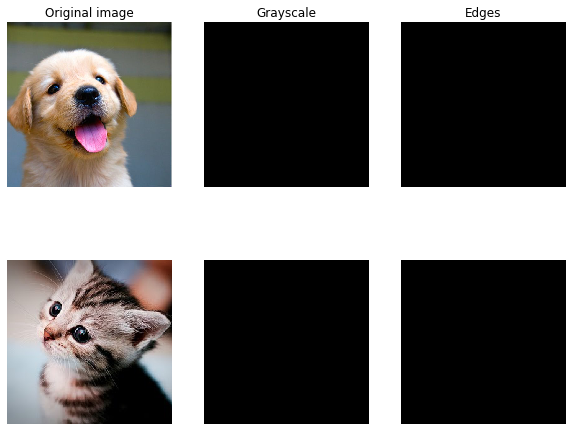

In [4]:
from imageio import imread
from PIL import Image

kitten = imread('cs231n/notebook_images/kitten.jpg')
puppy = imread('cs231n/notebook_images/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [ ]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

# Max-Pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [ ]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

# Max-Pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [ ]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

# Fast layers

Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it either execute the local development cell (option A) if you are developing locally, or the Colab cell (option B) if you are running this assignment in Colab.

---

**Very Important, Please Read**. For **both** option A and B, you have to **restart** the notebook after compiling the cython extension. In Colab, please save the notebook `File -> Save`, then click `Runtime -> Restart Runtime -> Yes`. This will restart the kernel which means local variables will be lost. Just re-execute the cells from top to bottom and skip the cell below as you only need to run it once for the compilation step.

---

## Option A: Local Development

Go to the cs231n directory and execute the following in your terminal:

```bash
python setup.py build_ext --inplace
```

## Option B: Colab

Execute the cell below only only **ONCE**.

In [ ]:
%cd drive/My\ Drive/$FOLDERNAME/cs231n/
!python setup.py build_ext --inplace

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [ ]:
# Rel errors should be around e-9 or less
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

In [ ]:
# Relative errors should be close to 0.0
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `cs231n/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks. Run the cells below to sanity check they're working.

In [ ]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

In [ ]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Remember you can use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [ ]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [ ]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [ ]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

In [ ]:
# Print final training accuracy
print(
    "Small data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

In [ ]:
# Print final validation accuracy
print(
    "Small data validation accuracy:",
    solver.check_accuracy(small_data['X_val'], small_data['y_val'])
)

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [ ]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

In [ ]:
# Print final training accuracy
print(
    "Full data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

In [ ]:
# Print final validation accuracy
print(
    "Full data validation accuracy:",
    solver.check_accuracy(data['X_val'], data['y_val'])
)

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

In [ ]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. As proposed in the original paper (link in `BatchNormalization.ipynb`), batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect every feature channel's statistics e.g. mean, variance to be relatively consistent both between different images, and different locations within the same image -- after all, every feature channel is produced by the same convolutional filter! Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

## Spatial batch normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [ ]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

In [ ]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

## Spatial batch normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [ ]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

# Group Normalization
In the previous notebook, we mentioned that Layer Normalization is an alternative normalization technique that mitigates the batch size limitations of Batch Normalization. However, as the authors of [2] observed, Layer Normalization does not perform as well as Batch Normalization when used with Convolutional Layers:

>With fully connected layers, all the hidden units in a layer tend to make similar contributions to the final prediction, and re-centering and rescaling the summed inputs to a layer works well. However, the assumption of similar contributions is no longer true for convolutional neural networks. The large number of the hidden units whose
receptive fields lie near the boundary of the image are rarely turned on and thus have very different
statistics from the rest of the hidden units within the same layer.

The authors of [3] propose an intermediary technique. In contrast to Layer Normalization, where you normalize over the entire feature per-datapoint, they suggest a consistent splitting of each per-datapoint feature into G groups, and a per-group per-datapoint normalization instead. 

<p align="center">
<img src="https://raw.githubusercontent.com/cs231n/cs231n.github.io/master/assets/a2/normalization.png">
</p>
<center>Visual comparison of the normalization techniques discussed so far (image edited from [3])</center>

Even though an assumption of equal contribution is still being made within each group, the authors hypothesize that this is not as problematic, as innate grouping arises within features for visual recognition. One example they use to illustrate this is that many high-performance handcrafted features in traditional Computer Vision have terms that are explicitly grouped together. Take for example Histogram of Oriented Gradients [4]-- after computing histograms per spatially local block, each per-block histogram is normalized before being concatenated together to form the final feature vector.

You will now implement Group Normalization. Note that this normalization technique that you are to implement in the following cells was introduced and published to ECCV just in 2018 -- this truly is still an ongoing and excitingly active field of research!

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)


[3] [Wu, Yuxin, and Kaiming He. "Group Normalization." arXiv preprint arXiv:1803.08494 (2018).](https://arxiv.org/abs/1803.08494)


[4] [N. Dalal and B. Triggs. Histograms of oriented gradients for
human detection. In Computer Vision and Pattern Recognition
(CVPR), 2005.](https://ieeexplore.ieee.org/abstract/document/1467360/)

## Group normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for group normalization in the function `spatial_groupnorm_forward`. Check your implementation by running the following:

In [ ]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 6, 4, 5
G = 2
x = 4 * np.random.randn(N, C, H, W) + 10
x_g = x.reshape((N*G,-1))
print('Before spatial group normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x_g.mean(axis=1))
print('  Stds: ', x_g.std(axis=1))

# Means should be close to zero and stds close to one
gamma, beta = np.ones((1,C,1,1)), np.zeros((1,C,1,1))
bn_param = {'mode': 'train'}

out, _ = spatial_groupnorm_forward(x, gamma, beta, G, bn_param)
out_g = out.reshape((N*G,-1))
print('After spatial group normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out_g.mean(axis=1))
print('  Stds: ', out_g.std(axis=1))

## Spatial group normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_groupnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [ ]:
np.random.seed(231)
N, C, H, W = 2, 6, 4, 5
G = 2
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(1,C,1,1)
beta = np.random.randn(1,C,1,1)
dout = np.random.randn(N, C, H, W)

gn_param = {}
fx = lambda x: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fg = lambda a: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]
fb = lambda b: spatial_groupnorm_forward(x, gamma, beta, G, gn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_groupnorm_forward(x, gamma, beta, G, gn_param)
dx, dgamma, dbeta = spatial_groupnorm_backward(dout, cache)
#You should expect errors of magnitudes between 1e-12~1e-07
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))